In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe
import mdtraj as md
import os
import shutil
import sys
sys.path.append('/storage1/francesco/scripts/BLOCKING/')
sys.path.append('/storage1/francesco/scripts/BME2/')
sys.path.append('/storage1/francesco/PROJECTS/IDP_EVO/MAIN/')
from main import BlockAnalysis
from block_tools import check
import BME
import analyse
import nglview as nv
from scipy.stats import gaussian_kde
import multiprocessing as mp
import itertools
import pymbar
import scipy.stats as scs

In [2]:
def quick_load( file ):
    dataset = pd.read_csv(file, delimiter=r"\s+", header = None, comment='#')
    return dataset.values

def rh_kirk(conf, n=24):
    invrij = (1-1/n)*(1/md.compute_distances(conf,conf.top.select_pairs('name CA','name CA'))).mean(axis=1)
    return 1/invrij

def hist_ss(ss,w):
    
    w = w/w.sum()
    
    ss_class = {'H':np.zeros(24),
                'B':np.zeros(24),
                'E':np.zeros(24),
                'G':np.zeros(24),
                'I':np.zeros(24),
                'T':np.zeros(24),
                'S':np.zeros(24),
                'C':np.zeros(24),
                'P':np.zeros(24)}
    
    for i in range(len(ss)):
        for r in range(24):
            ss_class[ss[i][r]][r] += w[i]
            
    return(ss_class)

def rchi2(calc,exp,err):
    a,b = np.polyfit(calc, exp, 1, w=1/err**2)
    calc = calc*a+b
    return ((calc-exp)**2/err**2).sum()/len(exp)

def kde_rh(a, w=None):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

def kde_rg(a, w=None):
    if type(w) == 'NoneType':
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = np.average(a, weights = w)
    return x,d,u

def bbtors_feat(trajs, pdb):
    t = md.load(trajs, top=pdb)
    _, phi = md.compute_phi(t)
    _, psi = md.compute_psi(t)
    
    f = np.zeros((np.shape(phi)[0],np.shape(phi)[1]*4))
    for i in range(np.shape(phi)[1]):
        p = i*4
        f[:,p] = np.cos(phi[...,i])
        f[:,p+1] = np.sin(phi[...,i])
        f[:,p+2] = np.cos(psi[...,i])
        f[:,p+3] = np.sin(psi[...,i])
        
    return f

In [3]:
T = (283,293,310,323)

## Analysis of the convergence of the simulations
### 1. Block averaging
### 2. Flat hills
### 3. CV diffusivity

In [4]:
BLOCK_rg = {}
for i,t in enumerate(T):
    _, rg, bias = np.loadtxt('/storage1/francesco/PROJECTS/HST5/SIMULATIONS/pbmetad{}_v6/RG_BIAS'.format(t), unpack=True)
    b = BlockAnalysis(rg,bias=bias,multi=2,T=t,interval_low=0.6,interval_up=2.5)
    b.SEM()
    BLOCK_rg[t] = b

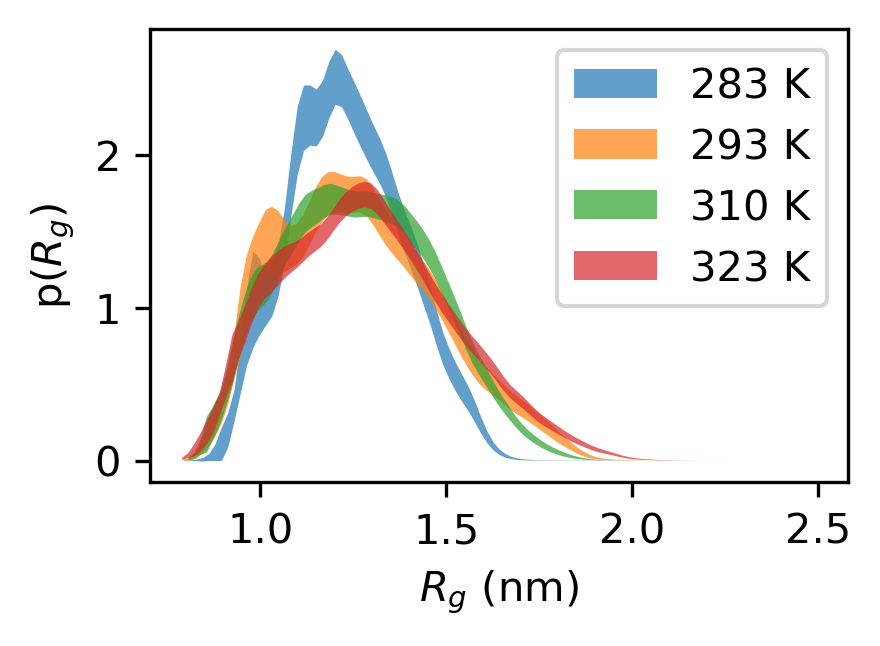

In [5]:
fig = plt.figure(figsize=(3,2), dpi=300)
for i,t in enumerate(T):
    binC, H, E = BLOCK_rg[t].get_pdf()
    plt.fill_between(binC, H-E, H+E,alpha=0.7,label='{} K'.format(t))
plt.legend()
plt.xlabel(r'$R_g$ (nm)')
plt.ylabel(r'p($R_g$)')

plt.savefig('rg_pdf.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

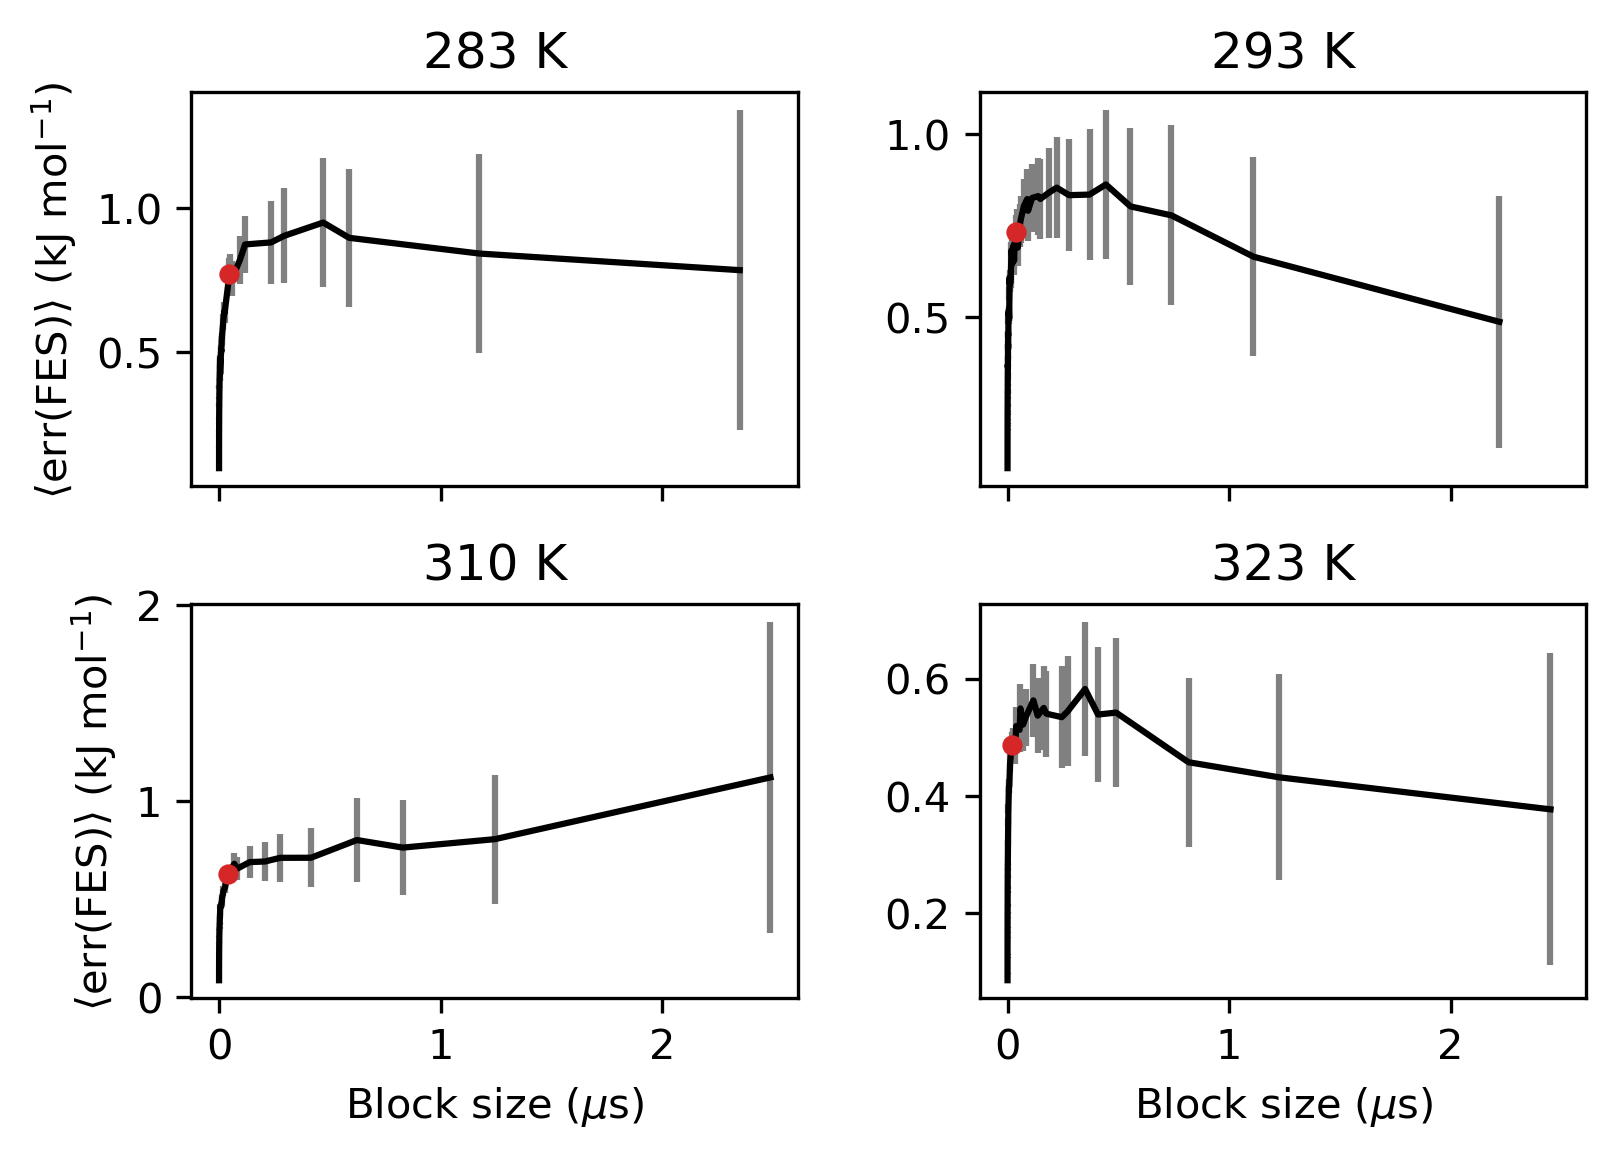

In [6]:
fig, axs = plt.subplots(nrows=2,ncols=2,dpi=300, sharex=True)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs = axs.flatten()
for i,t in enumerate(T):
    axs[i].set_title(str(t)+' K')
    axs[i].errorbar(BLOCK_rg[t].stat[...,0]/1e5,BLOCK_rg[t].stat[...,1],BLOCK_rg[t].stat[...,2],c='k',ecolor='0.5')
    axs[i].scatter(BLOCK_rg[t].bs/1e5,BLOCK_rg[t].sem,c='tab:red',zorder=1000,s=15)
    
axs[0].set_ylabel(r'$\langle$err(FES)$\rangle$ (kJ mol$^{-1}$)')
axs[2].set_ylabel(r'$\langle$err(FES)$\rangle$ (kJ mol$^{-1}$)')
axs[2].set_xlabel(r'Block size ($\mu$s)')
axs[3].set_xlabel(r'Block size ($\mu$s)')

plt.savefig('block.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [7]:
_ = quick_load( '/storage1/francesco/PROJECTS/HST5/SIMULATIONS/pbmetad{}_v6/HILLS.rg'.format(t) )

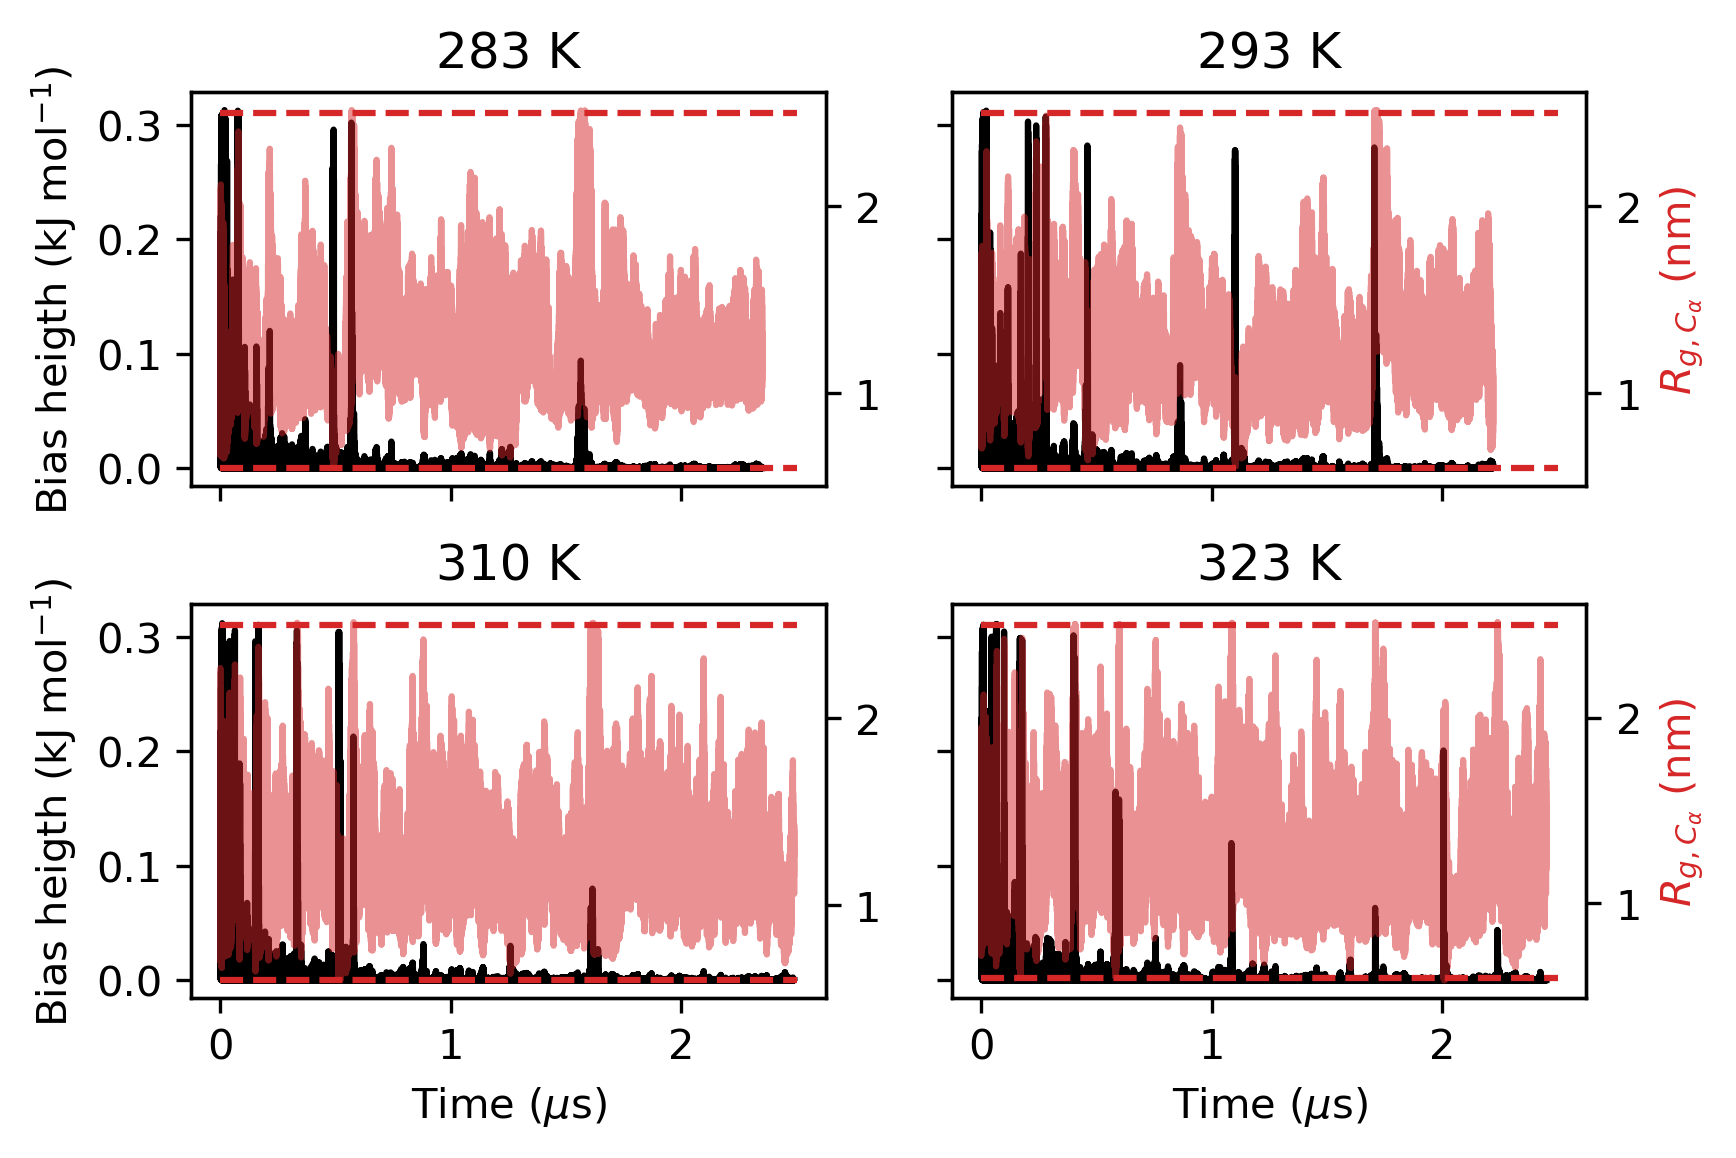

In [8]:
fig, axs = plt.subplots(nrows=2,ncols=2,dpi=300, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs = axs.flatten()
twins = []
for i,t in enumerate(T):
    axs[i].set_title(str(t)+' K')
    _ = quick_load( '/storage1/francesco/PROJECTS/HST5/SIMULATIONS/pbmetad{}_v6/HILLS.rg'.format(t) )
    
    twins.append(axs[i].twinx())
    twins[i].plot(_[...,0]/2e6*2, _[...,1],c = 'tab:red',alpha=0.5)

    axs[i].plot(_[...,0]/2e6*2, _[...,3],c = 'k')
    twins[i].hlines(2.5,0,2.5, ls='dashed',color='tab:red',zorder=1000)
    twins[i].hlines(0.6,0,2.5, ls='dashed',color='tab:red',zorder=1000)
    
    
axs[0].set_ylabel(r'Bias heigth (kJ mol$^{-1}$)')
axs[2].set_ylabel(r'Bias heigth (kJ mol$^{-1}$)')
axs[2].set_xlabel(r'Time ($\mu$s)')
axs[3].set_xlabel(r'Time ($\mu$s)')

twins[1].set_ylabel(r'$R_{g,C_{\alpha}}$ (nm)',color='tab:red')
twins[3].set_ylabel(r'$R_{g,C_{\alpha}}$ (nm)',color='tab:red')

plt.savefig('hills_rg.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

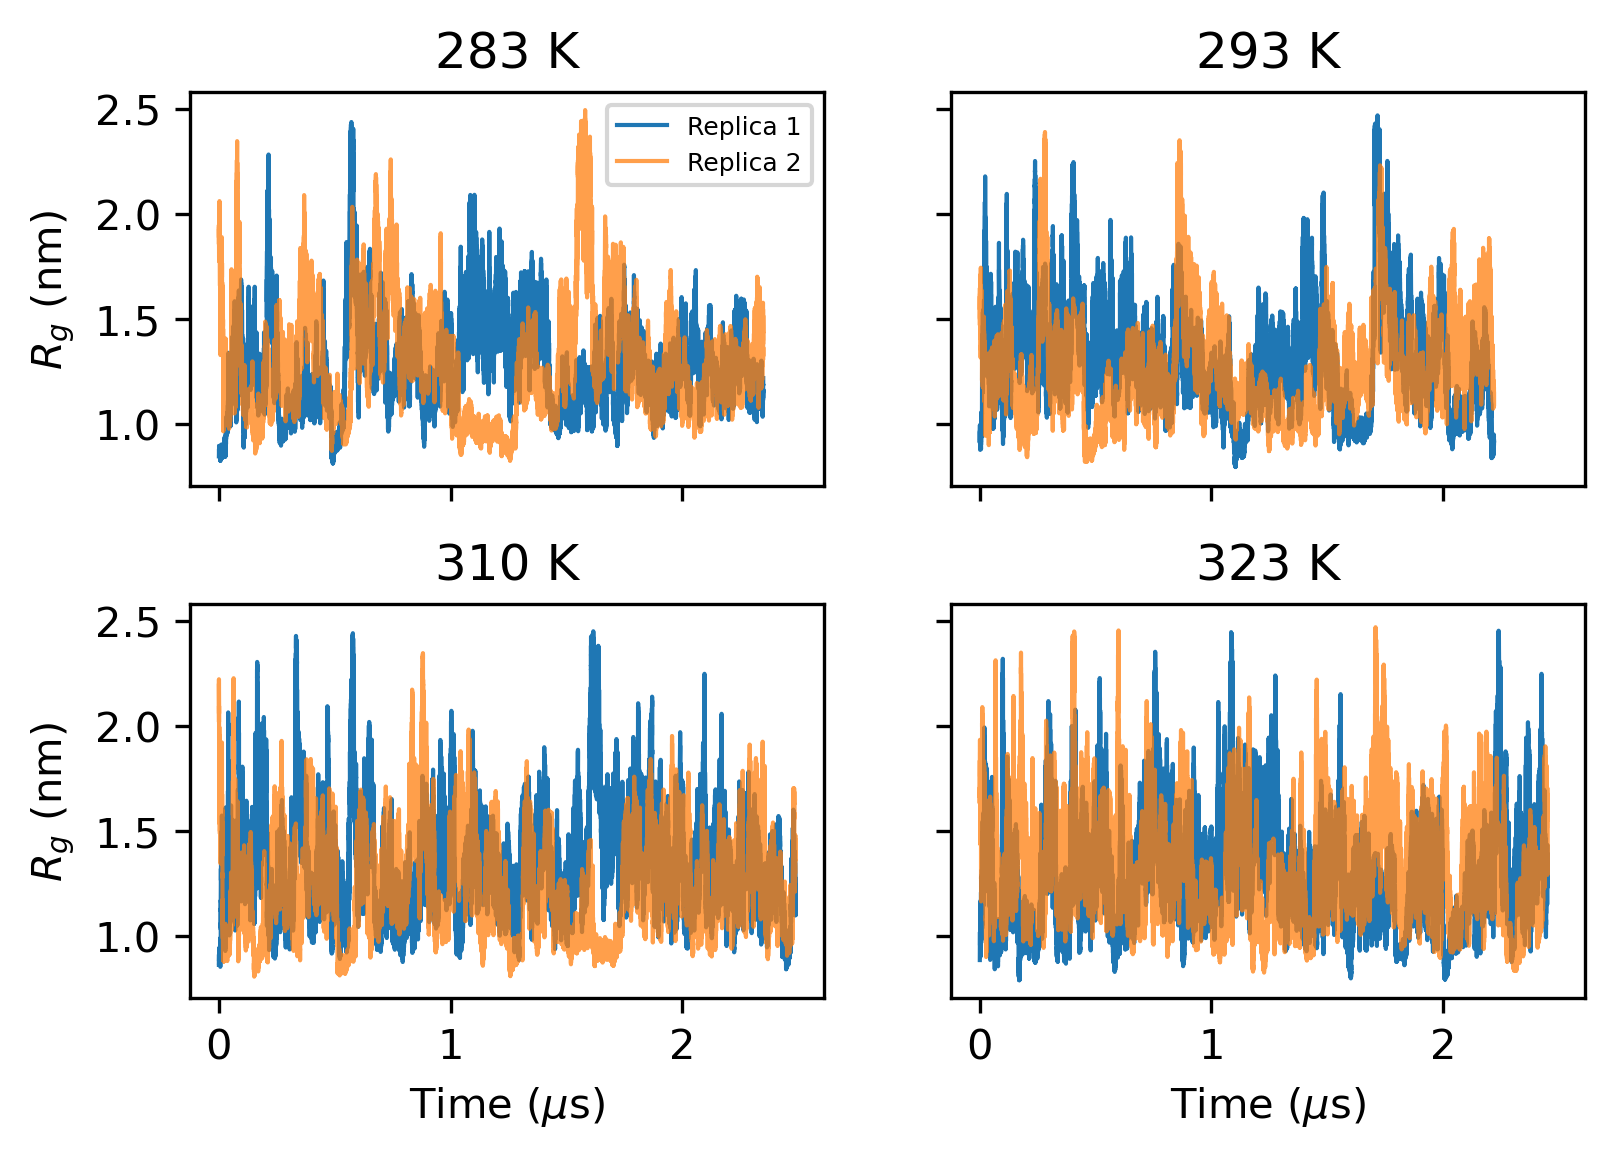

In [9]:
fig, axs = plt.subplots(nrows=2,ncols=2,dpi=300, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs = axs.flatten()
for i,t in enumerate(T):
    axs[i].set_title(str(t)+' K')
    axs[i].plot(BLOCK_rg[t].x[:int(len(BLOCK_rg[t].x)/2)], lw=1, label='Replica 1')
    axs[i].plot(BLOCK_rg[t].x[int(len(BLOCK_rg[t].x)/2):], alpha=0.75,lw=1, label='Replica 2')
    axs[i].set_xticks([0, 100000, 200000], labels=[0,1,2])
    
axs[0].set_ylabel(r'$R_g$ (nm)')
axs[2].set_ylabel(r'$R_g$ (nm)')
axs[2].set_xlabel(r'Time ($\mu$s)')
axs[3].set_xlabel(r'Time ($\mu$s)')

axs[0].legend(fontsize=6)

plt.savefig('rg_time.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [16]:
cv_phi = quick_load( '/storage1/francesco/PROJECTS/HST5/SIMULATIONS/pbmetad{}_v6/CV_PHI'.format(t) )[...,1:]
cv_psi = quick_load( '/storage1/francesco/PROJECTS/HST5/SIMULATIONS/pbmetad{}_v6/CV_PSI'.format(t) )[...,1:]

In [37]:
cv_phi0 = cv_phi[:int(len(cv_phi)/2)][::10]
cv_phi1 = cv_phi[int(len(cv_phi)/2):][::10]

cv_psi0 = cv_psi[:int(len(cv_psi)/2)][::10]
cv_psi1 = cv_psi[int(len(cv_psi)/2):][::10]

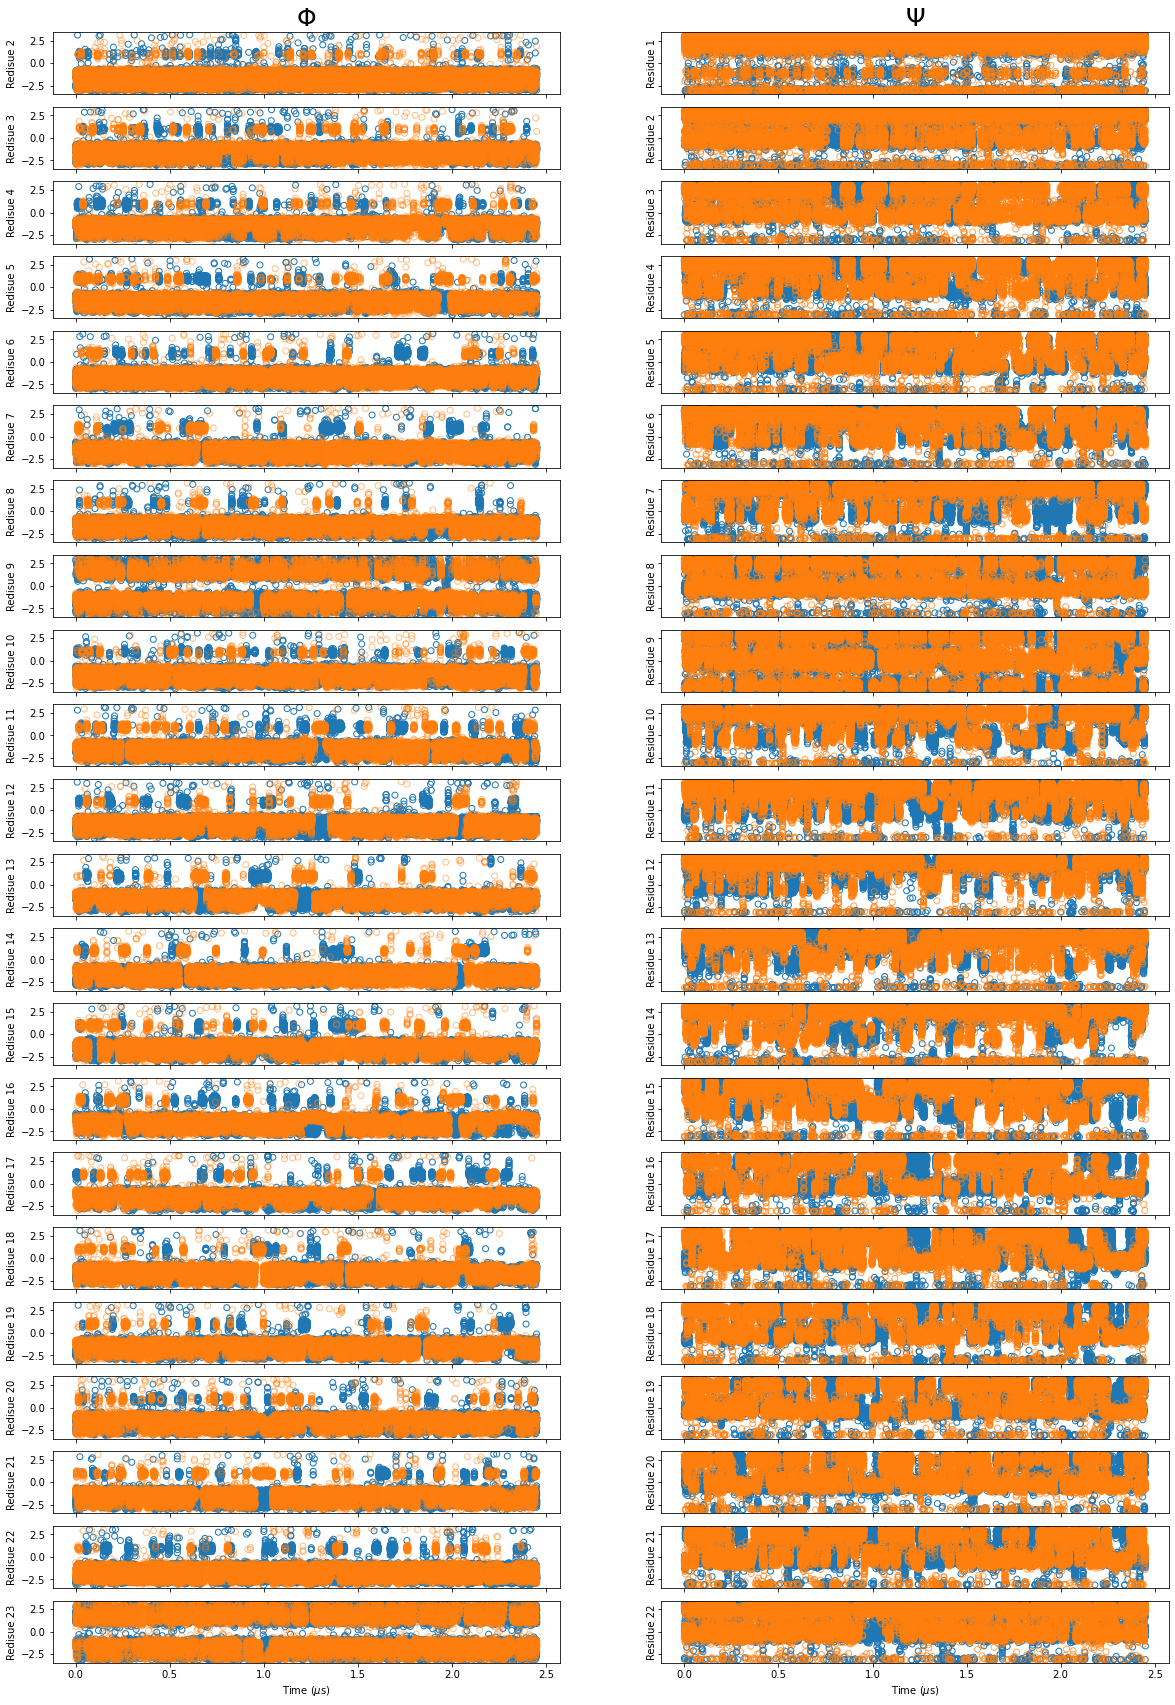

In [46]:
fig, axs = plt.subplots(22,2, sharex='col', sharey='row', figsize=(20,30))
for r in range(22):
    
    axs[r,0].scatter(np.arange(len(cv_phi0))/10000,cv_phi0[...,r], facecolors='none', edgecolors='tab:blue')
    axs[r,0].scatter(np.arange(len(cv_phi0))/10000,cv_phi1[...,r], facecolors='none', edgecolors='tab:orange',alpha=0.5)
    axs[r,0].set_ylabel('Redisue '+str(r+2))

    axs[r,1].scatter(np.arange(len(cv_phi0))/10000,cv_psi0[...,r], facecolors='none', edgecolors='tab:blue')
    axs[r,1].scatter(np.arange(len(cv_phi0))/10000,cv_psi1[...,r], facecolors='none', edgecolors='tab:orange',alpha=0.7)
    axs[r,1].set_ylabel('Residue '+str(r+1))

axs[0,0].set_title(r'$\Phi$', fontsize=25)
axs[0,1].set_title(r'$\Psi$', fontsize=25)
axs[r,0].set(xlabel=r'Time ($\mu$s)')
axs[r,1].set(xlabel=r'Time ($\mu$s)')

plt.savefig('bbtors_time.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Calculation of experimental observables

### 1. Subsampling

In [12]:
# for t in T:
#     c = 0
#     shutil.rmtree('pbmetad{}_v6/SUB_TRAJ'.format(t)) 
#     os.mkdir('pbmetad{}_v6/SUB_TRAJ'.format(t))
#     t0 = md.load_xtc('pbmetad{}_v6/trj0_noPBC.xtc'.format(t),top='top.pdb')[:int(BLOCK_rg[t].stat[-1,0])]
#     t1 = md.load_xtc('pbmetad{}_v6/trj1_noPBC.xtc'.format(t),top='top.pdb')[:int(BLOCK_rg[t].stat[-1,0])]
#     traj = t0+t1
#     for i in traj[0::10]:
#         i.save_pdb('pbmetad{}_v6/SUB_TRAJ/frame{}.pdb'.format(t,c))
#         c+=1

In [10]:
metad_w = {}
for t in T:
    metad_w[t] = BLOCK_rg[t].w[0::10]

### 2. Hydrodynamic radius

In [11]:
Rh_exp = np.array([
    [1.317, 0.028],
    [1.275, 0.024],
    [1.248, 0.018],
    [1.224, 0.017]
])

In [12]:
Rh_array = {}
for t in T:
    t0 = md.load_xtc('pbmetad{}_v6/trj0_noPBC.xtc'.format(t),top='top.pdb')[:int(BLOCK_rg[t].stat[-1,0])]
    t1 = md.load_xtc('pbmetad{}_v6/trj1_noPBC.xtc'.format(t),top='top.pdb')[:int(BLOCK_rg[t].stat[-1,0])]
    traj = t0+t1
    Rh_array[t] = rh_kirk(traj)

In [13]:
Rh_av_metad = []
for t in T:
    inv_av, inv_err =  BLOCK_rg[t].get_av_err(cv=1./Rh_array[t]) 
    Rh_av_metad.append([1./inv_av, (1./inv_av)**2*inv_err])
Rh_av_metad = np.array(Rh_av_metad)

In [14]:
# Prepare BME input
for i,t in enumerate(T):
    file = open('invRh_{}K.exp'.format(t),'w')
    file.write('# DATA=JCOUPLINGS\n')
    file.write('invRh {} {}'.format(1./Rh_exp[i,0],Rh_exp[i,1]/(Rh_exp[i,0]**2)))
    file.close()
    
    file = open('invRh_{}K.calc'.format(t),'w')
    for j,x in enumerate(Rh_array[t][0::10]):
        file.write('{} {}\n'.format(j,1./x))
    file.close()

In [15]:
THETA = [0.1,1,5,10,15,25,35,50,75,100,150,250,500,1000,10000]
BME_Rh_stats = {}
BME_Rh_w = {}
for t in T:
    BME_Rh_stats[t] = []
    BME_Rh_w[t] = []
    for theta in THETA:
        rew = BME.Reweight('invRh_{}K_theta_{}'.format(t, theta),w0=metad_w[t])
        rew.load('invRh_{}K.exp'.format(t), 'invRh_{}K.calc'.format(t))
        chi2_bef, chi2_aft, phi = rew.fit(theta=theta)
        BME_Rh_stats[t].append( [theta, chi2_bef, chi2_aft, phi] ) 
        BME_Rh_w[t].append(rew.get_weights())
    BME_Rh_stats[t] = np.array(BME_Rh_stats[t])

In [16]:
BME_Rh_stats_323 = {}
BME_Rh_w_323 = {}
for t in T:
    BME_Rh_stats_323[t] = []
    BME_Rh_w_323[t] = []
    for theta in THETA:
        rew = BME.Reweight('invRh_{}K_theta_{}'.format(t, theta),w0=metad_w[323])
        rew.load('invRh_{}K.exp'.format(t), 'invRh_323K.calc'.format(t))
        chi2_bef, chi2_aft, phi = rew.fit(theta=theta)
        BME_Rh_stats_323[t].append( [theta, chi2_bef, chi2_aft, phi] ) 
        BME_Rh_w_323[t].append(rew.get_weights())
    BME_Rh_stats_323[t] = np.array(BME_Rh_stats_323[t])

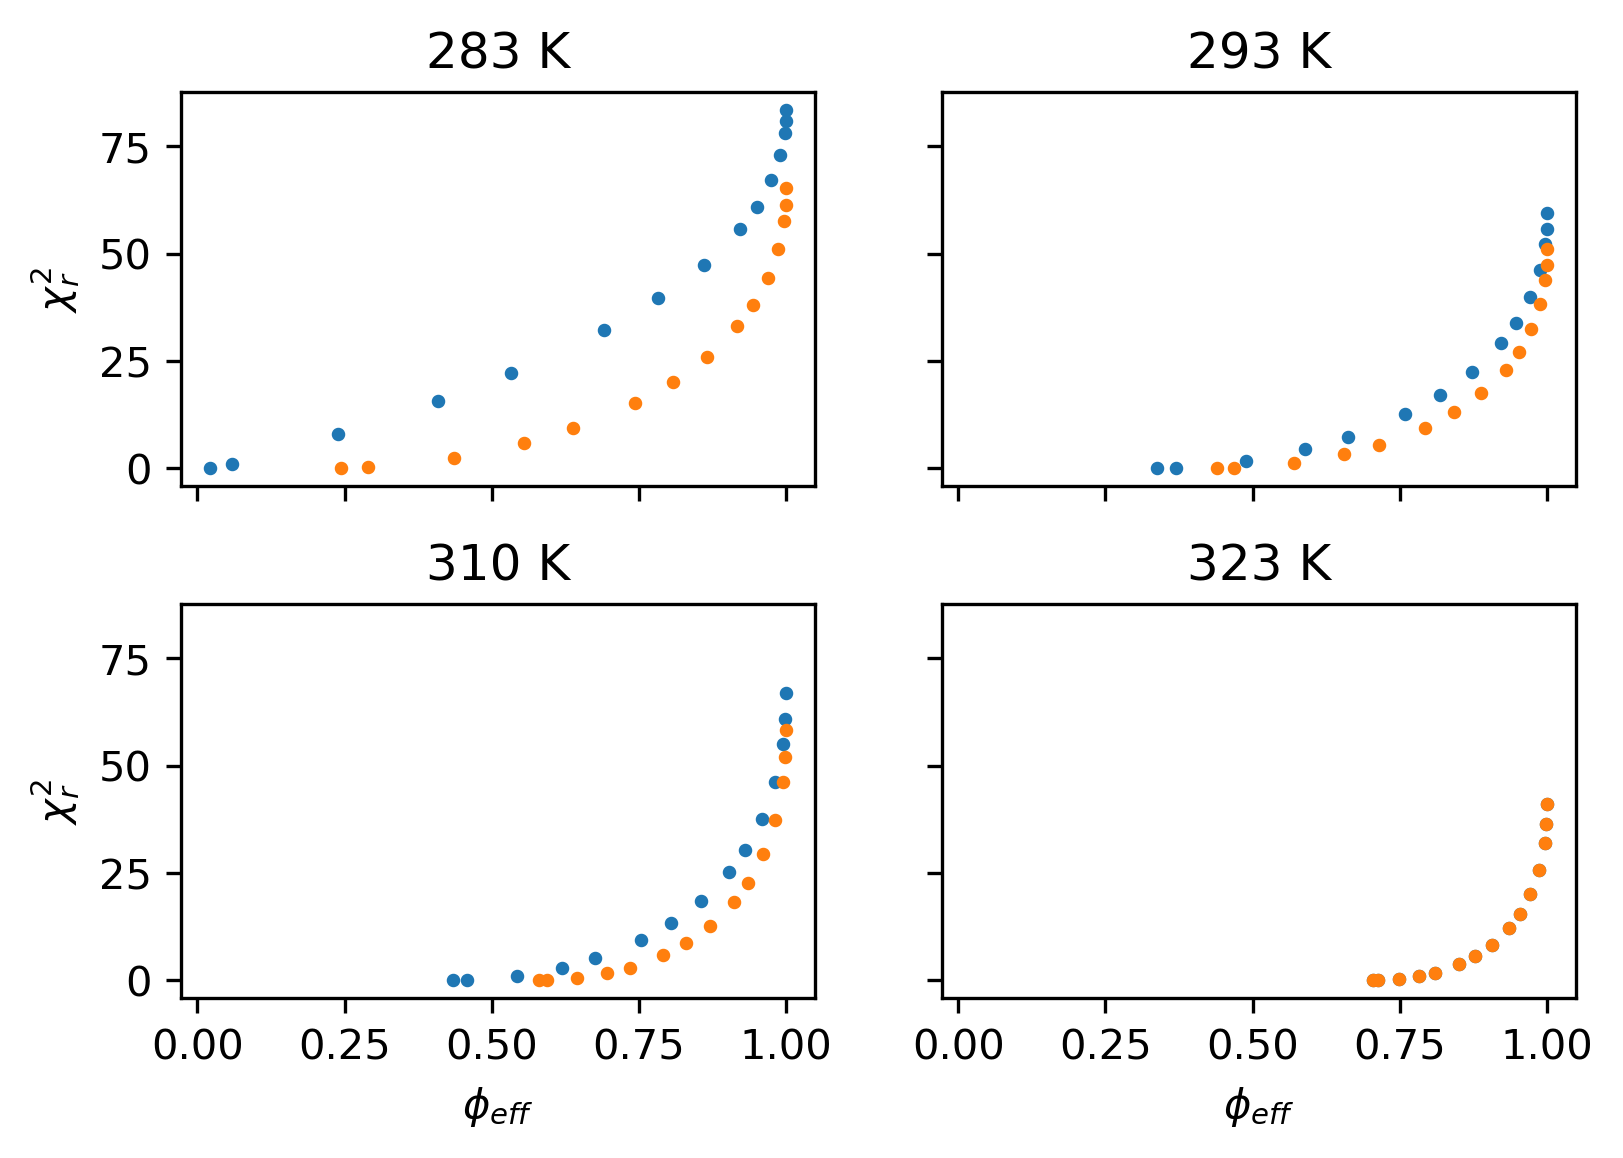

In [18]:
fig, axs = plt.subplots(nrows=2,ncols=2,dpi=300, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs = axs.flatten()
for i,t in enumerate(T):
    axs[i].set_title(str(t)+' K')
    axs[i].scatter(BME_Rh_stats[t][...,3],BME_Rh_stats[t][...,2],s=5)
    axs[i].scatter(BME_Rh_stats_323[t][...,3],BME_Rh_stats_323[t][...,2],s=5)
        
axs[0].set_ylabel(r'$\chi^2_r$')
axs[2].set_ylabel(r'$\chi^2_r$')
axs[2].set_xlabel(r'$\phi_{eff}$')
axs[3].set_xlabel(r'$\phi_{eff}$')
plt.show()

In [19]:
bme_rh_w = {}
phi_eff = []
for t in T:
    ndx = np.where(np.array(THETA)==5)[0][0]
    bme_rh_w[t] = BME_Rh_w[t][ndx]
    phi_eff.append(BME_Rh_stats[t][ndx,3])
    print(BME_Rh_stats[t][ndx])

[ 5.         83.72529004  7.97806578  0.23907139]
[ 5.         59.74663363  1.63413463  0.48797998]
[ 5.         67.71562452  1.02002127  0.54280585]
[ 5.         41.58642121  0.29220935  0.74859086]


In [20]:
bme_rh_w_323 = {}
phi_eff_323 = []
for t in T:
    ndx = np.where(np.array(THETA)==1)[0][0]
    bme_rh_w_323[t] = BME_Rh_w_323[t][ndx]
    phi_eff_323.append(BME_Rh_stats_323[t][ndx,3])
    print(BME_Rh_stats_323[t][ndx])

[ 1.         65.71832686  0.17958935  0.28950215]
[ 1.         51.40882275  0.07028655  0.46881977]
[1.00000000e+00 5.91538009e+01 2.56485356e-02 5.93597582e-01]
[1.00000000e+00 4.15864212e+01 1.41123882e-02 7.13628301e-01]


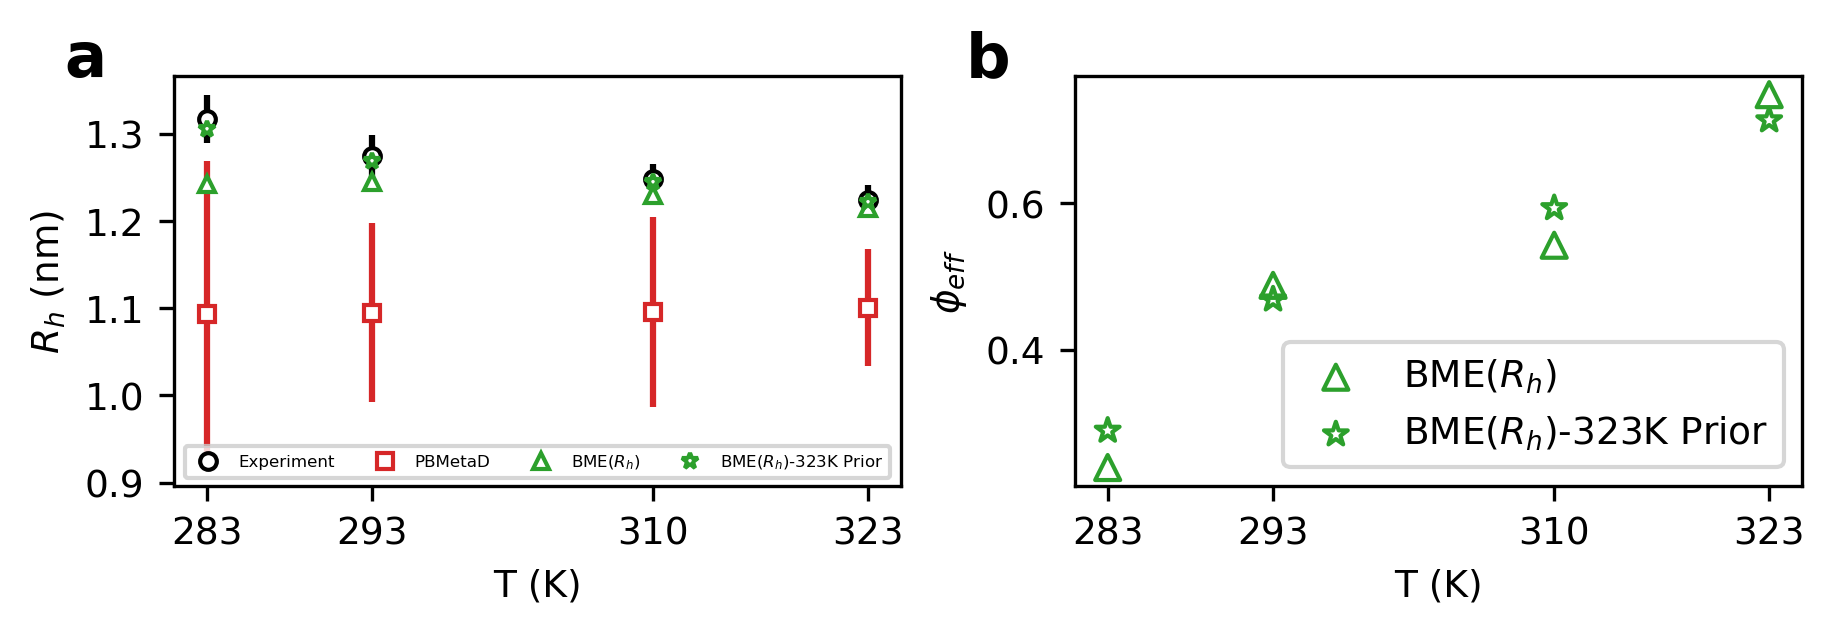

In [371]:
fig, (axs) = plt.subplots(ncols=2, nrows=1, figsize=(6,2), dpi=300, layout='constrained')

l1=axs[0].errorbar(T, Rh_exp[...,0], Rh_exp[...,1], ls='', marker='o',c='k',label=r'Experiment',markersize=4, mfc='w')
l2=axs[0].errorbar(T, Rh_av_metad[...,0], Rh_av_metad[...,1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
l3=axs[0].errorbar(T, Rh_av_rh_bme, ls='', marker='^',c='tab:green',label=r'BME($R_h$)',markersize=4, mfc='w')
axs[0].errorbar(T, Rh_av_rh_bme_323, ls='', marker='*',c='tab:green',label=r'BME($R_h$)-323K Prior',markersize=4, mfc='w')
axs[0].set_xticks(T)
axs[0].set_xlabel('T (K)')
axs[0].set_ylabel(r'$R_h$ (nm)')
axs[0].legend(ncol=4,fontsize=4, loc='lower center')

axs[1].scatter(T, phi_eff,label=r'BME($R_h$)',marker='^',facecolors='none',edgecolors='tab:green')
axs[1].scatter(T, phi_eff_323,label=r'BME($R_h$)-323K Prior',facecolors='none',edgecolors='tab:green', marker='*')
axs[1].set_ylabel(r'$\phi_{eff}$')
axs[1].set_xlabel(r'T (K)')
axs[1].set_xticks(T)
axs[1].legend(loc='lower right')

for a,l in zip(axs,['a','b','c','d']):
    a.text(-0.15,1, l, fontsize=15, weight='bold', transform=a.transAxes)
    
plt.savefig('rh_rew_323.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

### 3. SAXS & Rg

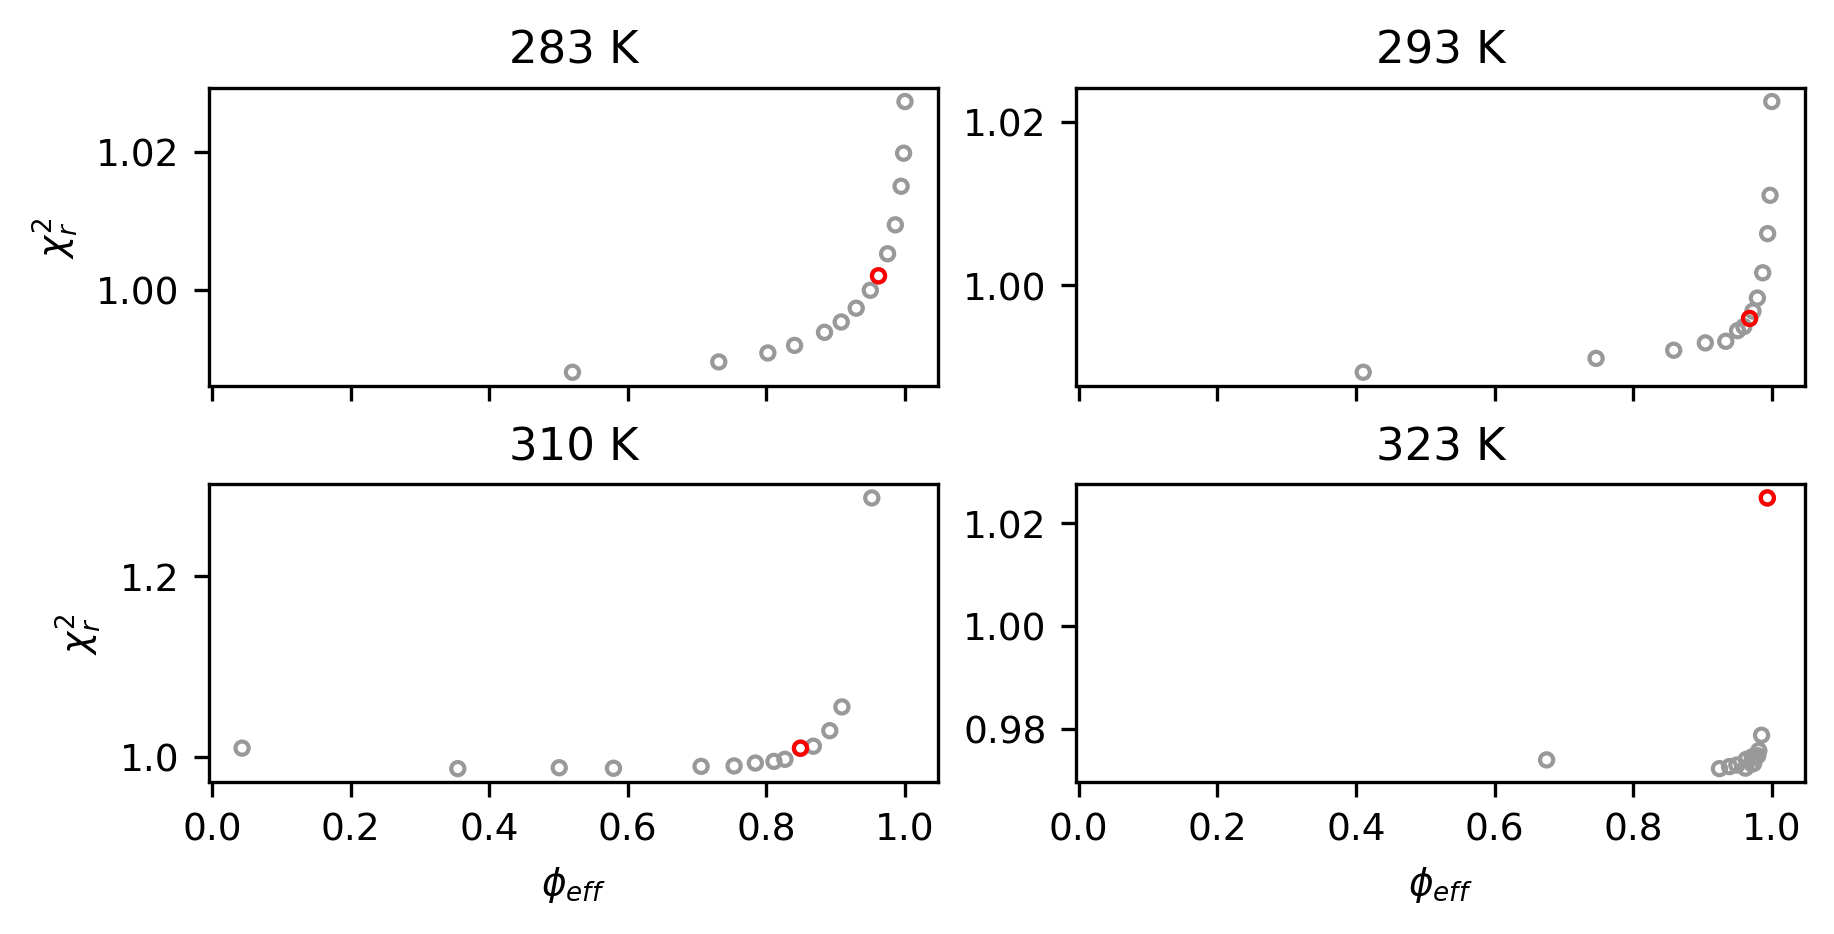

In [324]:
mpl.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,3), dpi=300,sharex=True, layout="constrained")
axs = axs.flatten()

theta_saxs = (100,75,150,10000)
for i,t in enumerate(T):
    theta,chi2,phi = np.loadtxt('stats_ibme_{}.dat'.format(t), unpack=True)
    axs[i].scatter(phi,chi2,facecolors='none', edgecolors='0.6',s=10)
    ndx = np.where(theta == theta_saxs[i])
    axs[i].scatter(phi[ndx], chi2[ndx], facecolors='none', edgecolors='r',s=10,zorder=100)
    axs[i].set_title('{} K'.format(t))
axs[0].set_ylabel(r'$\chi^2_r$')
axs[2].set_ylabel(r'$\chi^2_r$')
axs[2].set_xlabel(r'$\phi_{eff}$')
axs[3].set_xlabel(r'$\phi_{eff}$')

plt.savefig('tscan_saxs.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [13]:
for t in T:
    np.savetxt('w0_{}.dat'.format(t), metad_w[t])

In [130]:
saxs_params = {
          # d_rho, r0/rm
    'col': (r'$\delta\rho$', r'$r_0$'),
    '283 K': (8.0, 1.025), #GP183
    '293 K': (8.0, 1.025), #GP183
    '310 K': (6.0, 1.075), #GP163
    '323 K': (6.0, 1.050)  #GP162
}

pd.DataFrame(saxs_params).set_index('col').to_latex(buf='pepsi.param.tex')

In [131]:
! cat pepsi.param.tex

\begin{tabular}{lrrrr}
\toprule
{} &  283 K &  293 K &  310 K &  323 K \\
col          &        &        &        &        \\
\midrule
\$\textbackslash delta\textbackslash rho\$ &  8.000 &  8.000 &  6.000 &   6.00 \\
\$r\_0\$        &  1.025 &  1.025 &  1.075 &   1.05 \\
\bottomrule
\end{tabular}


In [22]:
bme_saxs_w = {}
for t in T:
    bme_saxs_w[t]=np.loadtxt('{}_bme_saxs.weights'.format(t))[...,1]

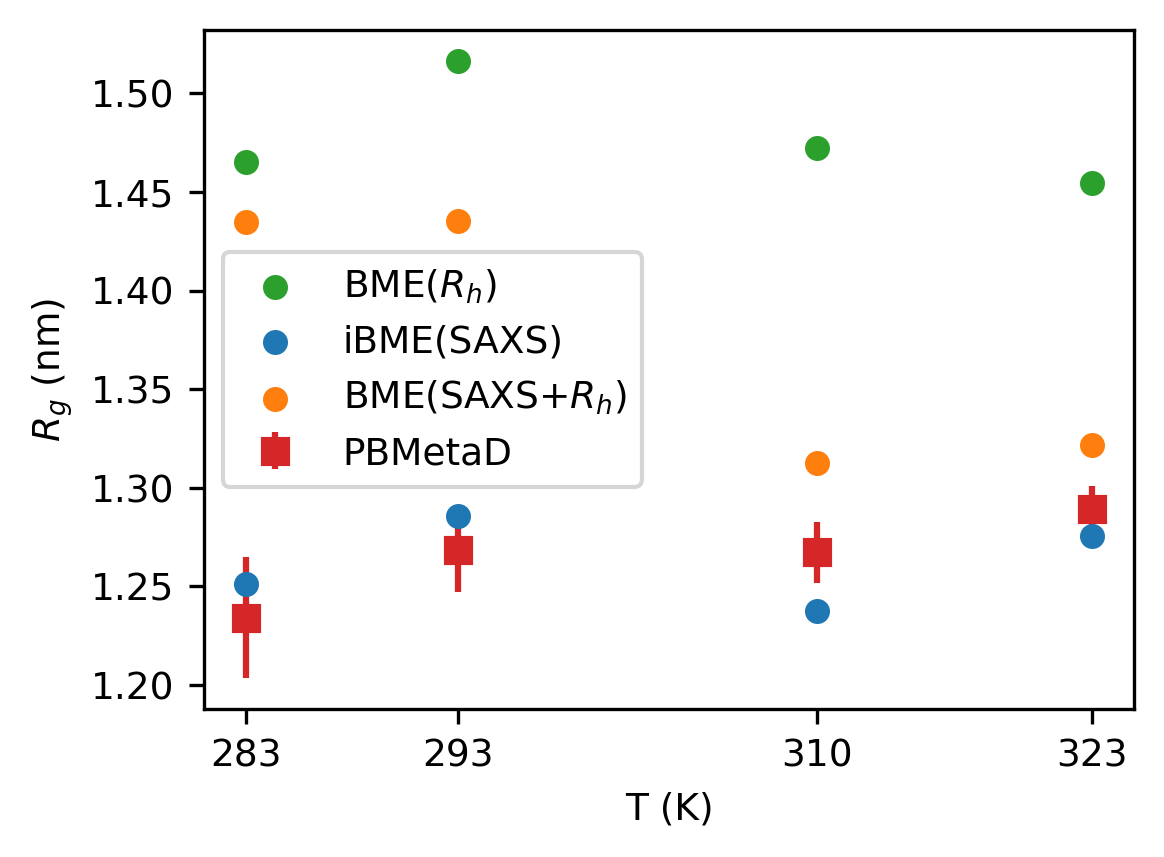

In [328]:
fig = plt.figure(figsize=(4,3), dpi=300)
plt.errorbar(T, [BLOCK_rg[t].get_av_err()[0] for t in T], [BLOCK_rg[t].get_av_err()[1] for t in T], ls='', marker='s',c='tab:red',label=r'PBMetaD')
plt.scatter(T, [np.average(BLOCK_rg[t].x[0::10],weights=bme_rh_w[t]) for t in T], marker='o',c='tab:green',label=r'BME($R_h$)',zorder=100,s=25)
plt.scatter(T, [np.average(BLOCK_rg[t].x[0::10],weights=bme_saxs_w[t]) for t in T], marker='o',c='tab:blue',label=r'iBME(SAXS)',zorder=100,s=25)
plt.scatter(T, [np.average(BLOCK_rg[t].x[0::10],weights=w_bme_comb[i]) for i,t in enumerate(T)], marker='o',c='tab:orange',label=r'BME(SAXS+$R_h$)',zorder=100,s=25)
#plt.scatter(T, [np.average(rg_aggr, weights=mbar_w[t]) for t in T], marker='*',zorder=100,label=r'MBAR',s=25)
plt.ylabel(r'$R_g$ (nm)')
plt.xlabel(r'T (K)')
plt.xticks(T)
plt.legend()

plt.savefig('rg_rew.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [23]:
exp_saxs = {}
for t in T:
    exp_saxs[t]=np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Hst5/saxs{}k_bme.txt.bift'.format(t))

In [24]:
calc_saxs = {}
for t in T:
    calc_saxs[t]=quick_load('{}_bme_saxs.calc'.format(t))[...,1:]

### 5. BME comb - SAXS+Rh

In [25]:
# fake Rh exp dataset with same number of datapoint as SAXS
for i,t in enumerate(T):
    file = open('FinvRh_{}K.exp'.format(t),'w')
    file.write('# DATA=JCOUPLINGS\n')
    for n in range(len(exp_saxs[t][...,0])):
        file.write('invRh{} {} {}\n'.format(n,1./Rh_exp[i,0],Rh_exp[i,1]/(Rh_exp[i,0]**2)))
    file.close()
    
    file = open('FinvRh_{}K.calc'.format(t),'w')
    for j,x in enumerate(Rh_array[t][0::10]):
        s=str(j)+" "+((str(1./x)+" ")*len(exp_saxs[t][...,0]))+"\n"
        file.write(s)
    file.close()

In [26]:
BME_comb_stats = {}
BME_comb_w = {}
def combBME(t,theta):
    
    exp_saxs = '/storage1/francesco/PROJECTS/EXP_DATA/Hst5/saxs{}k_bme.txt.bift'.format(t)
    calc_saxs = '{}_bme_saxs.calc'.format(t)
    exp_rh = 'FinvRh_{}K.exp'.format(t)
    calc_rh = 'FinvRh_{}K.calc'.format(t)
    
    rew = BME.Reweight("BMEcomb_T{}_theta{}".format(t,theta), w0=metad_w[t])
    rew.load(exp_saxs,calc_saxs,fit="no")
    rew.load(exp_rh,calc_rh)
    
    chi2_bef, chi2_aft, phi = rew.fit(theta=theta)
    #print(theta, chi2_bef, chi2_aft, phi)
    BME_comb_stats[t].append( [theta, chi2_bef, chi2_aft, phi] ) 
    BME_comb_w[t].append(rew.get_weights())

In [27]:
THETAS = [500000,100000,35000,10000,5000,3000,2000,1500,1000]

In [28]:
for t in T:
    BME_comb_stats[t] = []
    BME_comb_w[t] = []
    for theta in THETAS:
        combBME(t, theta)

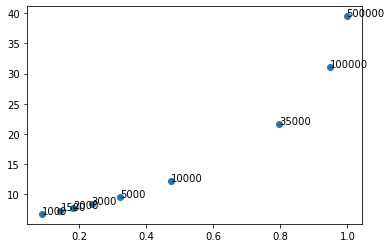

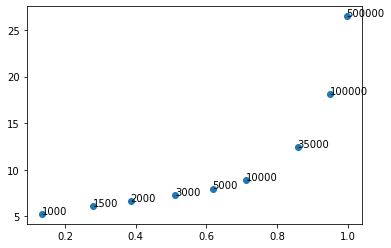

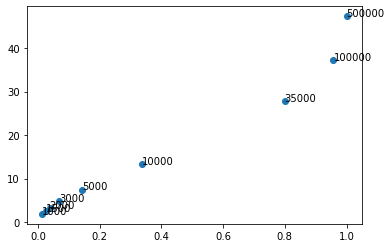

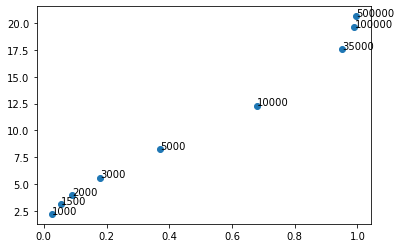

In [29]:
for t in T:
    plt.scatter(np.array(BME_comb_stats[t])[...,3],np.array(BME_comb_stats[t])[...,2])
    for a in BME_comb_stats[t]:
        plt.annotate(a[0], (a[3], a[2]), fontsize=10)
    plt.show()

In [30]:
w_bme_comb = [BME_comb_w[283][4], BME_comb_w[293][4], BME_comb_w[310][3], BME_comb_w[323][4]]

## Kirkwood-Riseman eq from COM

In [374]:
def generate_dummy_trajectory(traj,xyz):
    """Convert xyz coordinates and box vectors into an MDTraj Trajectory (with Topology)."""

    n_atoms = np.shape(xyz)[1]
    data = []

    for i in range(n_atoms):
        data.append(dict(serial=i, name="H", element="H", resSeq=i + 1, resName="UNK", chainID=0))

    data = pd.DataFrame(data)
    unitcell_lengths = traj.unitcell_lengths
    unitcell_angles = traj.unitcell_angles
    top = md.Topology.from_dataframe(data, np.zeros((0, 2), dtype='int'))
    traj = md.Trajectory(xyz, top, unitcell_lengths=unitcell_lengths, unitcell_angles=unitcell_angles)

    return traj

def generate_cm_traj(traj):
    c_xyz = []
    for res in range(len(list(traj.topology.residues))):
        atoms = traj.top.select("residue {}".format(res))
        c_xyz.append(md.compute_center_of_mass(traj.atom_slice(atoms)))
    c_xyz = np.swapaxes(np.array(c_xyz),0,1)
    c_traj = generate_dummy_trajectory(traj,c_xyz)
    return c_traj

def cm_rh(traj):
    c_traj = generate_cm_traj(traj)
    n = np.shape(c_traj.xyz)[1]
    return 1./( (1-1/n)*(1/md.compute_distances(c_traj,c_traj.top.select_pairs('all','all'))).mean(axis=1) )

In [375]:
t0 = md.load_xtc('pbmetad{}_v6/trj0_noPBC.xtc'.format(293),top='top.pdb')[:int(BLOCK_rg[293].stat[-1,0])]
t1 = md.load_xtc('pbmetad{}_v6/trj1_noPBC.xtc'.format(293),top='top.pdb')[:int(BLOCK_rg[293].stat[-1,0])]
traj = t0+t1

In [377]:
c_xyz = []
for frame in traj[0::100]:
    frame_cm = []
    for res in range(1,25):
        atoms = frame.top.select("residue {}".format(res))
        respos = frame.xyz[:, atoms,...][0].mean(axis=0)
        frame_cm.append(respos)
    c_xyz.append(np.array(frame_cm))
c_xyz = np.array(c_xyz)

In [378]:
c_xyz = []
for res in range(1,25):
    atoms = traj.top.select("residue {}".format(res))
    c_xyz.append(md.compute_center_of_geometry(traj[0::100].atom_slice(atoms)))

In [379]:
c_xyz = np.swapaxes(np.array(c_xyz),0,1)

In [381]:
c_traj = generate_dummy_trajectory(traj[0::100],c_xyz)

In [382]:
rh_c_293 = 1./( (1-1/n)*(1/md.compute_distances(c_traj,c_traj.top.select_pairs('all','all'))).mean(axis=1) )

In [395]:
disp_c = np.histogram2d(rh_c_293,BLOCK_rg[293].x[0::100], weights=BLOCK_rg[293].w[0::100], bins=30)

In [403]:
disp_c_fes = -np.log(disp_c[0])*0.008314462618*293
disp_c_fes -= disp_c_fes.min()

<ipython-input-403-0bcfd30a3e71>:1: RuntimeWarning: divide by zero encountered in log
  disp_c_fes = -np.log(disp_c[0])*0.008314462618*293


In [405]:
rh_COM_calv = np.loadtxt('/storage1/francesco/PROJECTS/RH/Rh_COM_hst5.dat')

In [407]:
calv_c = np.histogram2d(rh_COM_calv,rg_calvados[0::10], bins=20)

<ipython-input-411-0def1aa78f31>:12: RuntimeWarning: divide by zero encountered in log
  ax.contour(-np.log(calv_c[0]),levels=1,extent=(calv_c[2][0],calv_c[2][-1],calv_c[1][0],calv_c[1][-1]),colors='#ffbf00',linewidths=2)


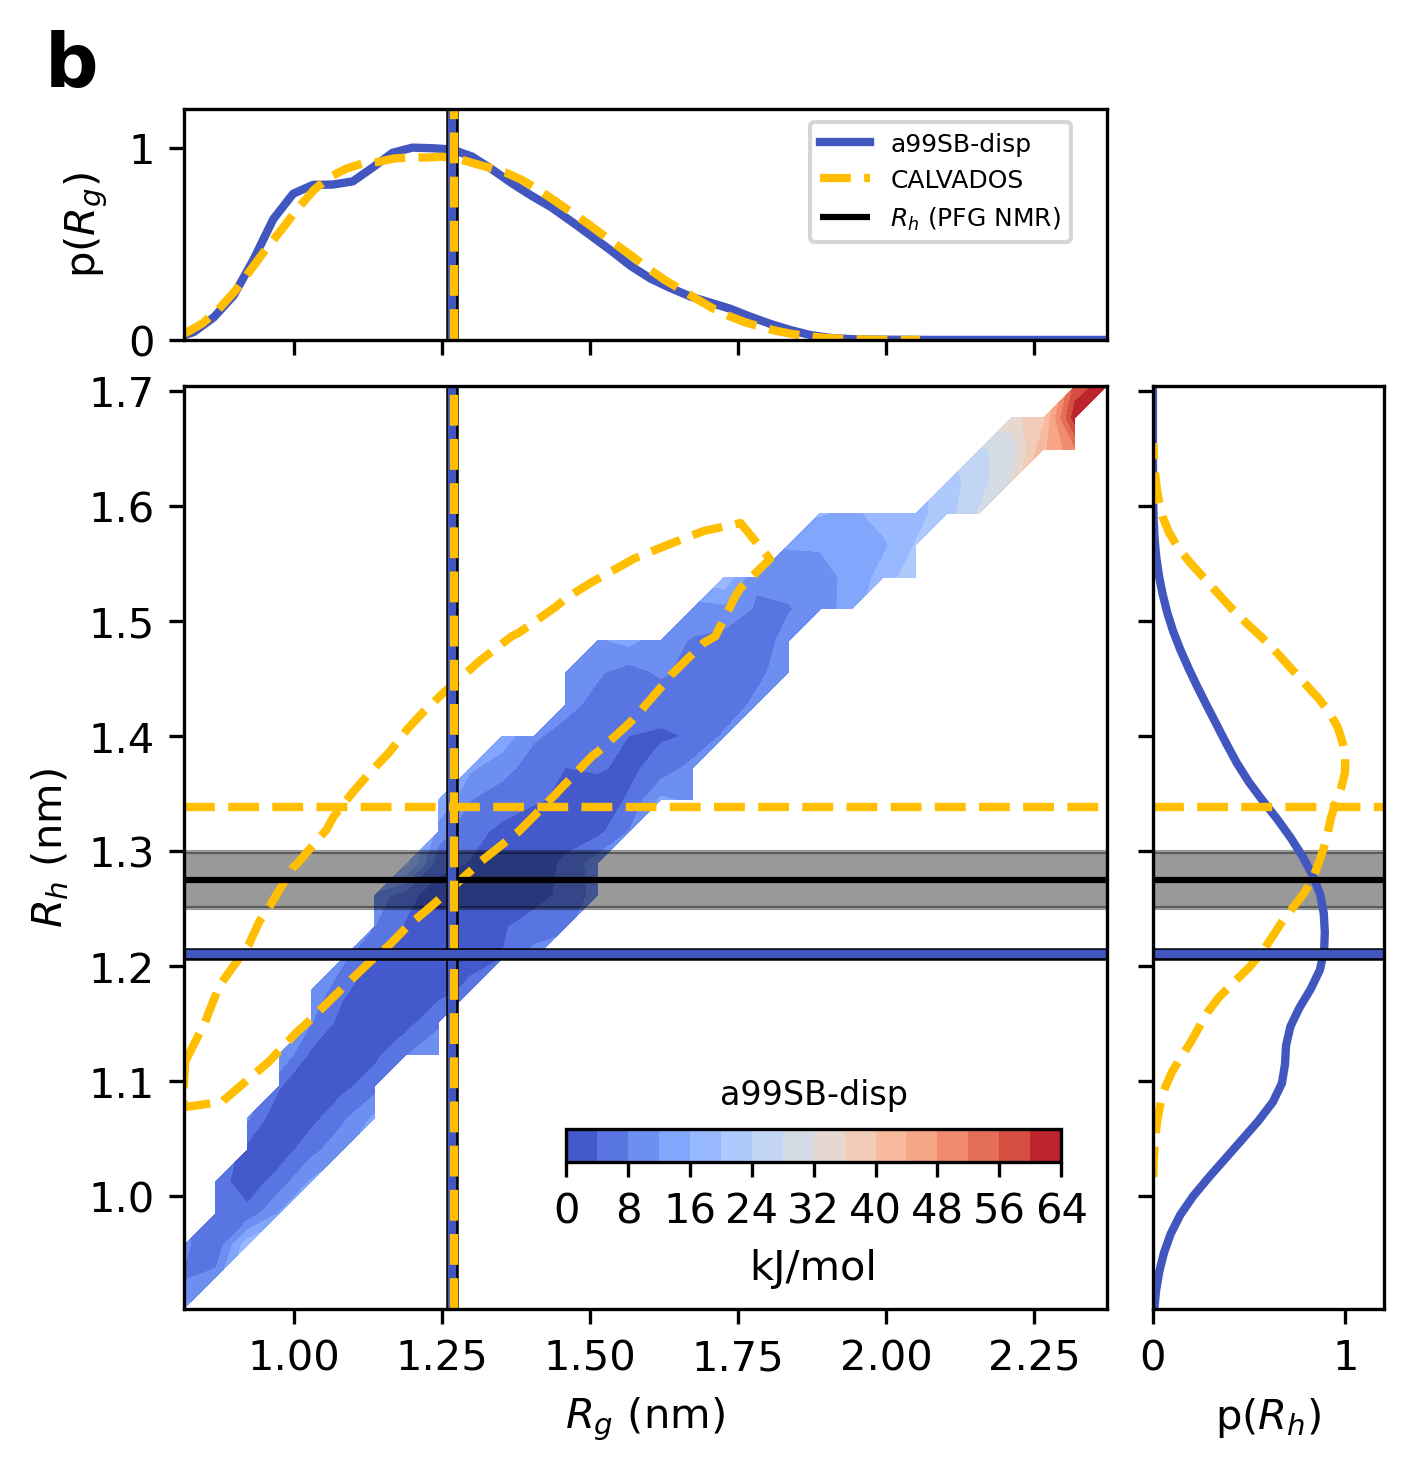

In [411]:
mpl.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(5, 5), dpi=300)

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.08, hspace=0.08)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

im = ax.contourf(disp_c_fes, cmap='coolwarm',levels=15,extent=(disp_c[2][0],disp_c[2][-1],disp_c[1][0],disp_c[1][-1]))
ax.contour(-np.log(calv_c[0]),levels=1,extent=(calv_c[2][0],calv_c[2][-1],calv_c[1][0],calv_c[1][-1]),colors='#ffbf00',linewidths=2)
ax.hlines(Rh_exp[1][0],disp_c[2][0],disp_c[2][-1],label='Experimental',color='k')
ax.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax.set_xlim(disp_c[2][0],disp_c[2][-1])
ax.set_ylim(disp_c[1][0],disp_c[1][-1])
ax_histy.set_ylim(disp_c[1][0],disp_c[1][-1])
ax_histx.set_xlim(disp_c[2][0],disp_c[2][-1])

rg_disp = kde_rg(BLOCK_rg[293].x[0::10],w=BLOCK_rg[293].w[0::10])
scale = np.max(rg_disp[1])
rg_calv = kde_rg(rg_calvados)
ax_histx.plot(rg_disp[0],rg_disp[1]/scale,lw=2,label=r'a99SB-disp',c='#4256BF')
ax_histx.plot(rg_calv[0],rg_calv[1]/scale,c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.vlines(rg_disp[2],disp_c[1][0],disp_c[1][-1],color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histx.vlines(rg_disp[2],0,1.2,color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.vlines(rg_calv[2],disp_c[1][0],disp_c[1][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histx.vlines(rg_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

rh_calv = kde_rh(rh_COM_calv)
scale = np.max(rh_calv[1])
rh_disp = kde_rh(rh_c_293,w=BLOCK_rg[293].w[0::100])
ax_histy.plot(rh_disp[1]/scale,rh_disp[0],lw=2,label=r'a99SB-disp',c='#4256BF')
ax_histy.plot(rh_calv[1]/scale,rh_calv[0],c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.hlines(rh_disp[2],disp_c[2][0],disp_c[2][-1],color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histy.hlines(rh_disp[2],0,1.2,color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.hlines(rh_calv[2],disp_c[2][0],disp_c[2][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histy.hlines(rh_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

ax_histx.set_xticklabels([])
ax_histx.set_ylabel(r'p($R_g$)')
ax_histx.set_ylim(0,1.2)
ax_histy.set_yticklabels([])
ax_histy.set_xlabel(r'p($R_h$)')
ax_histy.hlines(Rh_exp[1][0],0,1.2,label=r'$R_h$ (PFG NMR)',color='k')
ax_histy.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax_histy.set_xlim(0,1.2)
ax.set_xlabel(r'$R_g$ (nm)')
ax.set_ylabel(r'$R_h$ (nm)')
ax.set_box_aspect(1)

cbax = fig.add_axes([0.47, 0.12, 0.1, 0.1])
cbax.axis('off')
cbax.set_title(r'a99SB-disp',fontsize=8)
cb = plt.colorbar(im, ax=cbax, orientation='horizontal',shrink=3.3,fraction=1,format='%.d',label='kJ/mol',aspect=15)

ax_histx.text(-0.15,1.1, 'b', fontsize=18, weight='bold', transform=ax_histx.transAxes)
ax_histy.legend(fontsize=6,bbox_to_anchor=(-0.3,1.3,0,0))

plt.savefig('fes_rh_COM.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Reweighted Obs

In [34]:
Rh_av_rh_bme = []
Rh_av_rh_bme_323 = []
Rh_av_saxs_bme = []
Rh_av_bme_comb = []
for i,t in enumerate(T):
    Rh_av_rh_bme.append(1./np.average(1./Rh_array[t][0::10], weights=bme_rh_w[t]))
    Rh_av_rh_bme_323.append(1./np.average(1./Rh_array[323][0::10], weights=bme_rh_w_323[t]))
    Rh_av_saxs_bme.append(1./np.average(1./Rh_array[t][0::10], weights=bme_saxs_w[t]))
    Rh_av_bme_comb.append(1./np.average(1./Rh_array[t][0::10], weights=w_bme_comb[i]))

In [35]:
saxs_chi2_metad = []
saxs_chi2_bme_rh = []
#saxs_chi2_bme_rh_323 = []
saxs_chi2_bme_saxs = []
saxs_chi2_bme_comb = []
for i,t in enumerate(T):
    av = np.average(calc_saxs[t], weights=metad_w[t], axis=0)
    saxs_chi2_metad.append( rchi2(av,exp_saxs[t][...,1],exp_saxs[t][...,2]) )
    
    av = np.average(calc_saxs[t], weights=bme_rh_w[t], axis=0)
    saxs_chi2_bme_rh.append( rchi2(av,exp_saxs[t][...,1],exp_saxs[t][...,2]) )
    
    av = np.average(calc_saxs[t], weights=bme_saxs_w[t], axis=0)
    saxs_chi2_bme_saxs.append( rchi2(av,exp_saxs[t][...,1],exp_saxs[t][...,2]) )
    
    av = np.average(calc_saxs[t], weights=w_bme_comb[i], axis=0)
    saxs_chi2_bme_comb.append( rchi2(av,exp_saxs[t][...,1],exp_saxs[t][...,2]) )

In [36]:
SS = {}
SS_metad = {}
SS_bme_rh = {}
SS_bme_rh_323 = {}
SS_bme_saxs = {}
SS_bme_comb = {}
for i,t in enumerate(T):
    ss = np.genfromtxt('pbmetad{}_v6/SS.dat'.format(t), dtype='str')
    SS[t] = ss
    SS_metad[t] = hist_ss(ss, w=metad_w[t])
    SS_bme_rh[t] = hist_ss(ss, w=bme_rh_w[t])
    SS_bme_saxs[t] = hist_ss(ss, w=bme_saxs_w[t])
    SS_bme_comb[t] = hist_ss(ss, w=w_bme_comb[i])
for t in T:
    ss = np.genfromtxt('pbmetad{}_v6/SS.dat'.format(323), dtype='str')
    SS_bme_rh_323[t] = hist_ss(ss, w=bme_rh_w_323[t])
    
av_ppii_metad = []
av_ppii_bme_rh = []
av_ppii_bme_rh_323 = []
av_ppii_bme_saxs = []
av_ppii_bme_comb = []
for t in T:
    av_ppii_metad.append( SS_metad[t]['P'].sum()/24 )
    av_ppii_bme_rh.append( SS_bme_rh[t]['P'].sum()/24 )
    av_ppii_bme_rh_323.append( SS_bme_rh_323[t]['P'].sum()/24 )
    av_ppii_bme_saxs.append( SS_bme_saxs[t]['P'].sum()/24 )
    av_ppii_bme_comb.append( SS_bme_comb[t]['P'].sum()/24 )
    
    
per_frame_ss = {}
for t in T:
    per_frame_ss[t] = [f.count('P') for f in SS[t]]

## Figure 1

In [39]:
rg_guinier = [[1.31,1.33,1.35,1.33],[0.012,0.055,0.014,0.01]]
rg_av_metad = [[BLOCK_rg[t].get_av_err()[0] for t in T], [BLOCK_rg[t].get_av_err()[1] for t in T]]

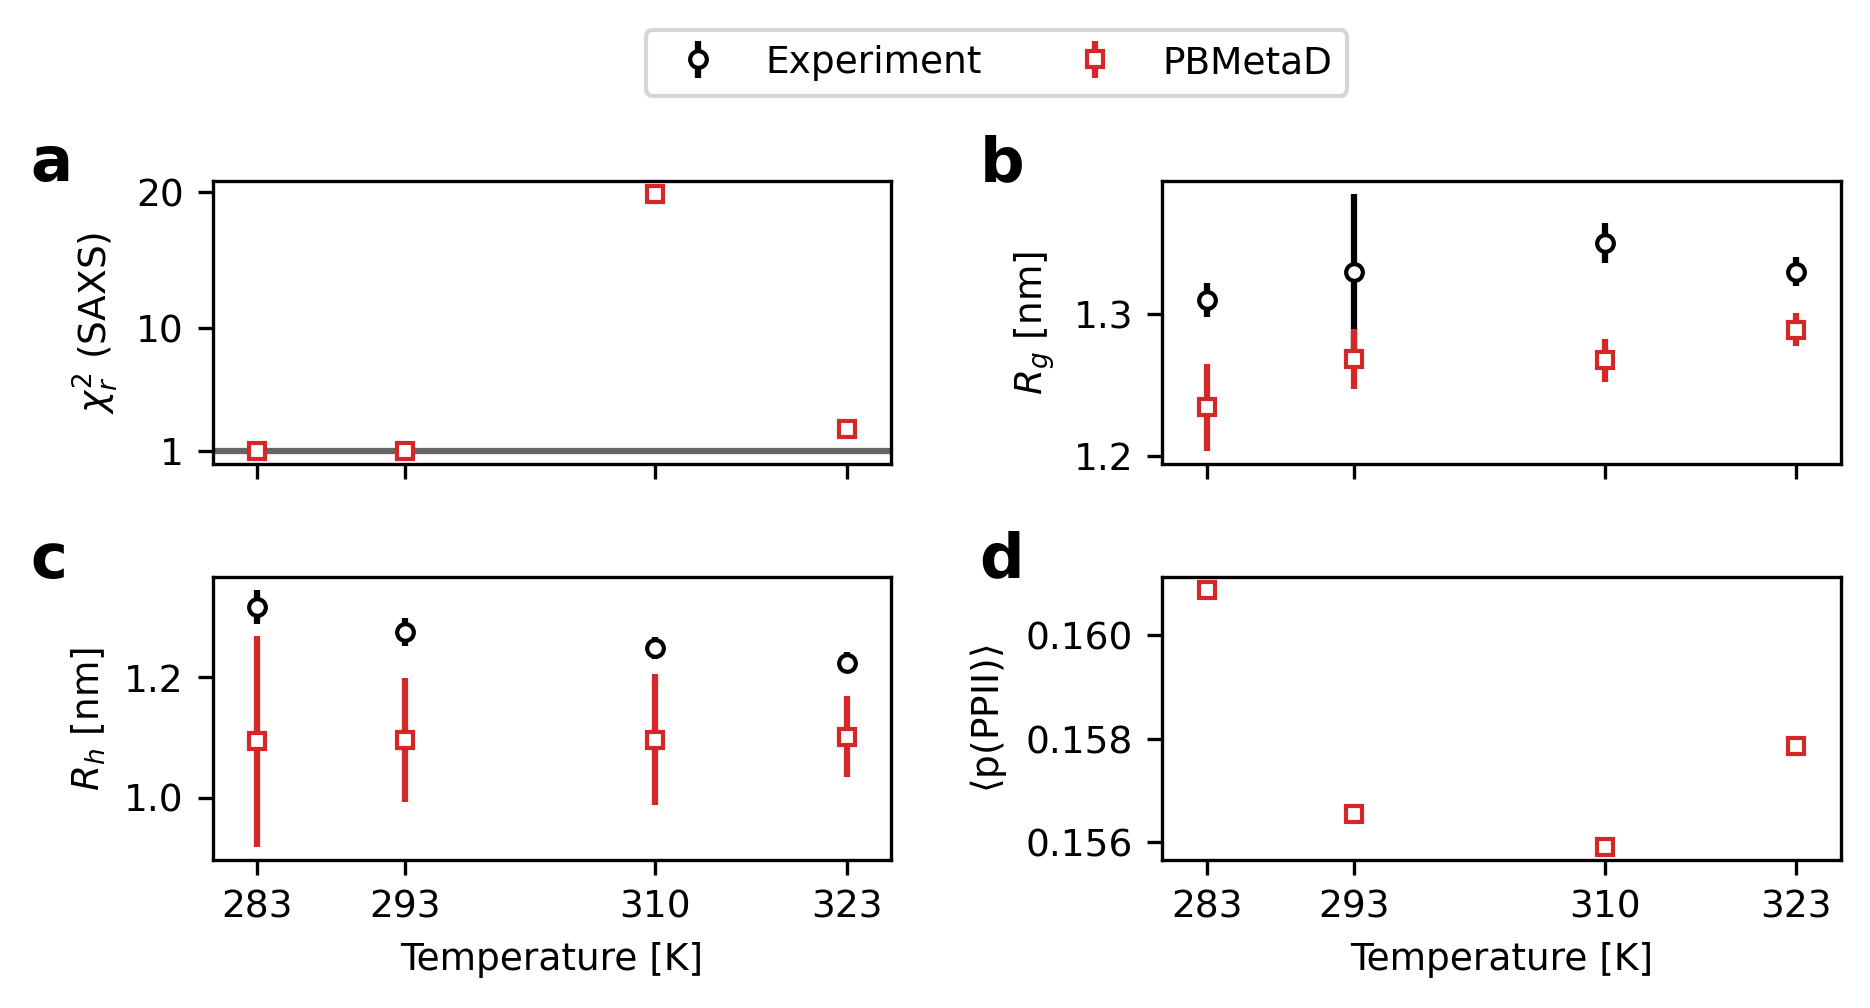

In [40]:
mpl.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7,3), dpi=300,sharex=True)
axs = axs.flatten()

axs[0].errorbar(T, saxs_chi2_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
axs[0].hlines(1,280,326,color='0.4')
axs[1].errorbar(T, rg_guinier[0], rg_guinier[1], ls='', marker='o',c='k',label=r'Experimental',markersize=4, mfc='w')
axs[1].errorbar(T, rg_av_metad[0], rg_av_metad[1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
axs[2].errorbar(T, Rh_exp[...,0], Rh_exp[...,1], ls='', marker='o',c='k',label=r'Experiment',markersize=4, mfc='w')
axs[2].errorbar(T, Rh_av_metad[...,0], Rh_av_metad[...,1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
axs[3].errorbar(T, av_ppii_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')

axs[0].set_ylabel(r'$\chi^2_r$ (SAXS)')
axs[0].set_xlim(280,326)
axs[0].set_yticks((1,10,20))
axs[1].set_ylabel(r'$R_g$ [nm]')
axs[2].set_ylabel(r'$R_h$ [nm]')
axs[2].set_xlabel(r'Temperature [K]')
axs[3].set_xlabel(r'Temperature [K]')
axs[3].set_ylabel(r'$\langle$p(PPII)$\rangle$')
plt.subplots_adjust(wspace=0.4,hspace=0.4)

axs[2].legend(ncol=2,bbox_to_anchor=(1.7,3, 0, 0))

for a,l in zip(axs,['a','b','c','d']):
    a.text(-0.27,1, l, fontsize=15, weight='bold', transform=a.transAxes)

plt.xticks(T)

plt.savefig('fig1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Figure 2

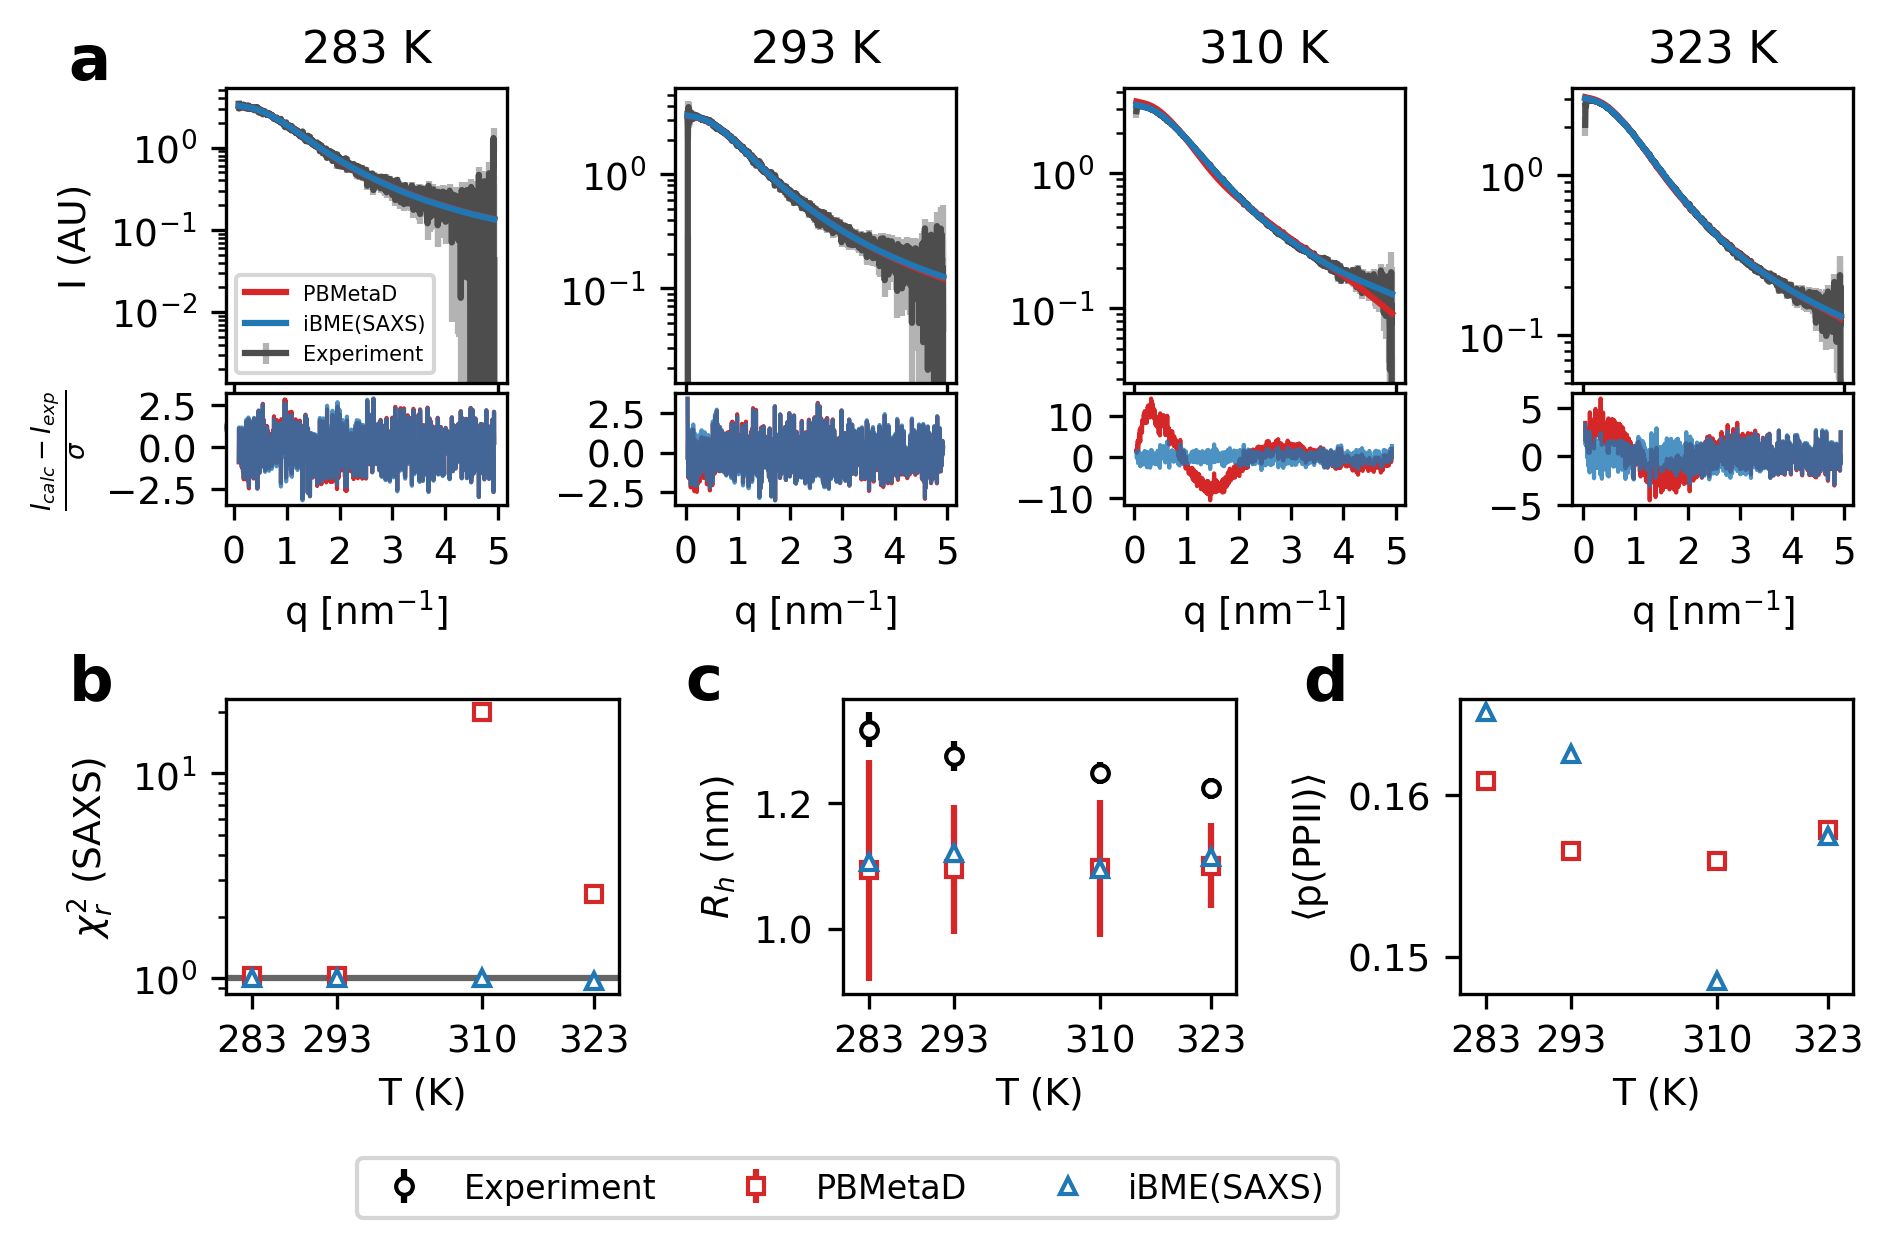

In [49]:
mpl.rcParams.update({'font.size': 9})
fig = plt.figure(figsize=(7,4), dpi=300)
gs = GridSpec(nrows=15, ncols=24+6, figure=fig, wspace=100)

ax1 = fig.add_subplot(gs[0:5, 0:6])
ax2 = fig.add_subplot(gs[0:5, 8:14])
ax3 = fig.add_subplot(gs[0:5, 16:22])
ax4 = fig.add_subplot(gs[0:5, 24:30])
ax5 = fig.add_subplot(gs[5:7, 0:6])
ax6 = fig.add_subplot(gs[5:7, 8:14])
ax7 = fig.add_subplot(gs[5:7, 16:22])
ax8 = fig.add_subplot(gs[5:7, 24:30])
ax9 = fig.add_subplot(gs[10:15, 0:8])
ax10 = fig.add_subplot(gs[10:15, 11:19])
ax11 = fig.add_subplot(gs[10:15, 22:30])

for axp, axr, t in zip([ax1,ax2,ax3,ax4], [ax5,ax6,ax7,ax8], T):
    axp.set_yscale('log')
    axp.set_title('{} K'.format(t))
    axp.errorbar(exp_saxs[t][...,0], exp_saxs[t][...,1], exp_saxs[t][...,2], c='0.3', ecolor='0.7', label='Experiment')
    calc = np.average(calc_saxs[t], axis=0, weights=metad_w[t])
    a,b = np.polyfit(calc, exp_saxs[t][...,1], 1, w=1/exp_saxs[t][...,2]**2)
    calc = calc*a+b
    axp.plot(exp_saxs[t][...,0], calc, zorder=10, c='tab:red', label='PBMetaD')
    axr.plot(exp_saxs[t][...,0], (calc-exp_saxs[t][...,1])/exp_saxs[t][...,2], c='tab:red', lw=1)
    
    calc = np.average(calc_saxs[t], axis=0, weights=bme_saxs_w[t])
    a,b = np.polyfit(calc, exp_saxs[t][...,1], 1, w=1/exp_saxs[t][...,2]**2)
    calc = calc*a+b
    axp.plot(exp_saxs[t][...,0], calc, zorder=10, c='tab:blue', label='iBME(SAXS)')
    axr.plot(exp_saxs[t][...,0], (calc-exp_saxs[t][...,1])/exp_saxs[t][...,2], c='tab:blue', lw=1, alpha=0.8)
    axr.set_xlabel(r'q [nm$^{-1}$]')
    axr.set_xticks([0,1,2,3,4,5])
ax4.set_ylim(0.05,3.5)
ax1.set_ylabel('I (AU)')
ax5.set_ylabel(r'$\frac{I_{calc}-I_{exp}}{\sigma}$')


ax9.errorbar(T, saxs_chi2_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
ax9.errorbar(T, saxs_chi2_bme_saxs, ls='', marker='^',c='tab:blue',label=r'BME(SAXS)',markersize=4, mfc='w')
ax9.set_xticks(T)
ax9.hlines(1,280,326,color='0.4')
ax9.set_xlim(280,326)
ax9.set_xlabel('T (K)')
ax9.set_ylabel(r'$\chi^2_r$ (SAXS)')
ax9.set_yscale('log')

ax10.errorbar(T, Rh_exp[...,0], Rh_exp[...,1], ls='', marker='o',c='k',label=r'Experiment',markersize=4, mfc='w')
ax10.errorbar(T, Rh_av_metad[...,0], Rh_av_metad[...,1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
ax10.errorbar(T, Rh_av_saxs_bme, ls='', marker='^',c='tab:blue',label=r'iBME(SAXS)',markersize=4, mfc='w')
ax10.set_xticks(T)
ax10.set_xlabel('T (K)')
ax10.set_ylabel(r'$R_h$ (nm)')
ax10.set_xlim(280,326)

ax11.errorbar(T, av_ppii_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
ax11.errorbar(T, av_ppii_bme_saxs, ls='', marker='^',c='tab:blue',label=r'BME(SAXS)',markersize=4, mfc='w')
ax11.set_xticks(T)
ax11.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax11.set_xlabel('T (K)')
ax11.set_ylabel(r'$\langle$p(PPII)$\rangle$')
ax11.set_xlim(280,326)

ax1.legend(fontsize=5)
ax1.text(-0.4,3.1, 'a', fontsize=15, weight='bold', transform=ax9.transAxes)
ax9.text(-0.4,1, 'b', fontsize=15, weight='bold', transform=ax9.transAxes)
ax10.text(-0.4,1, 'c', fontsize=15, weight='bold', transform=ax10.transAxes)
ax11.text(-0.4,1, 'd', fontsize=15, weight='bold', transform=ax11.transAxes)

ax10.legend(bbox_to_anchor=(1.3, -0.5, 0, 0), fontsize=8,ncol=3)

plt.savefig('fig2.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Figure 3

In [66]:
_ = np.vstack([check(Rh_array[323])[0::10], per_frame_ss[323]])
_ = gaussian_kde(_)(_)
idx = _.argsort()

In [67]:
z = np.log(_[idx])-np.log(_[idx]).min()
z = z / z.max()

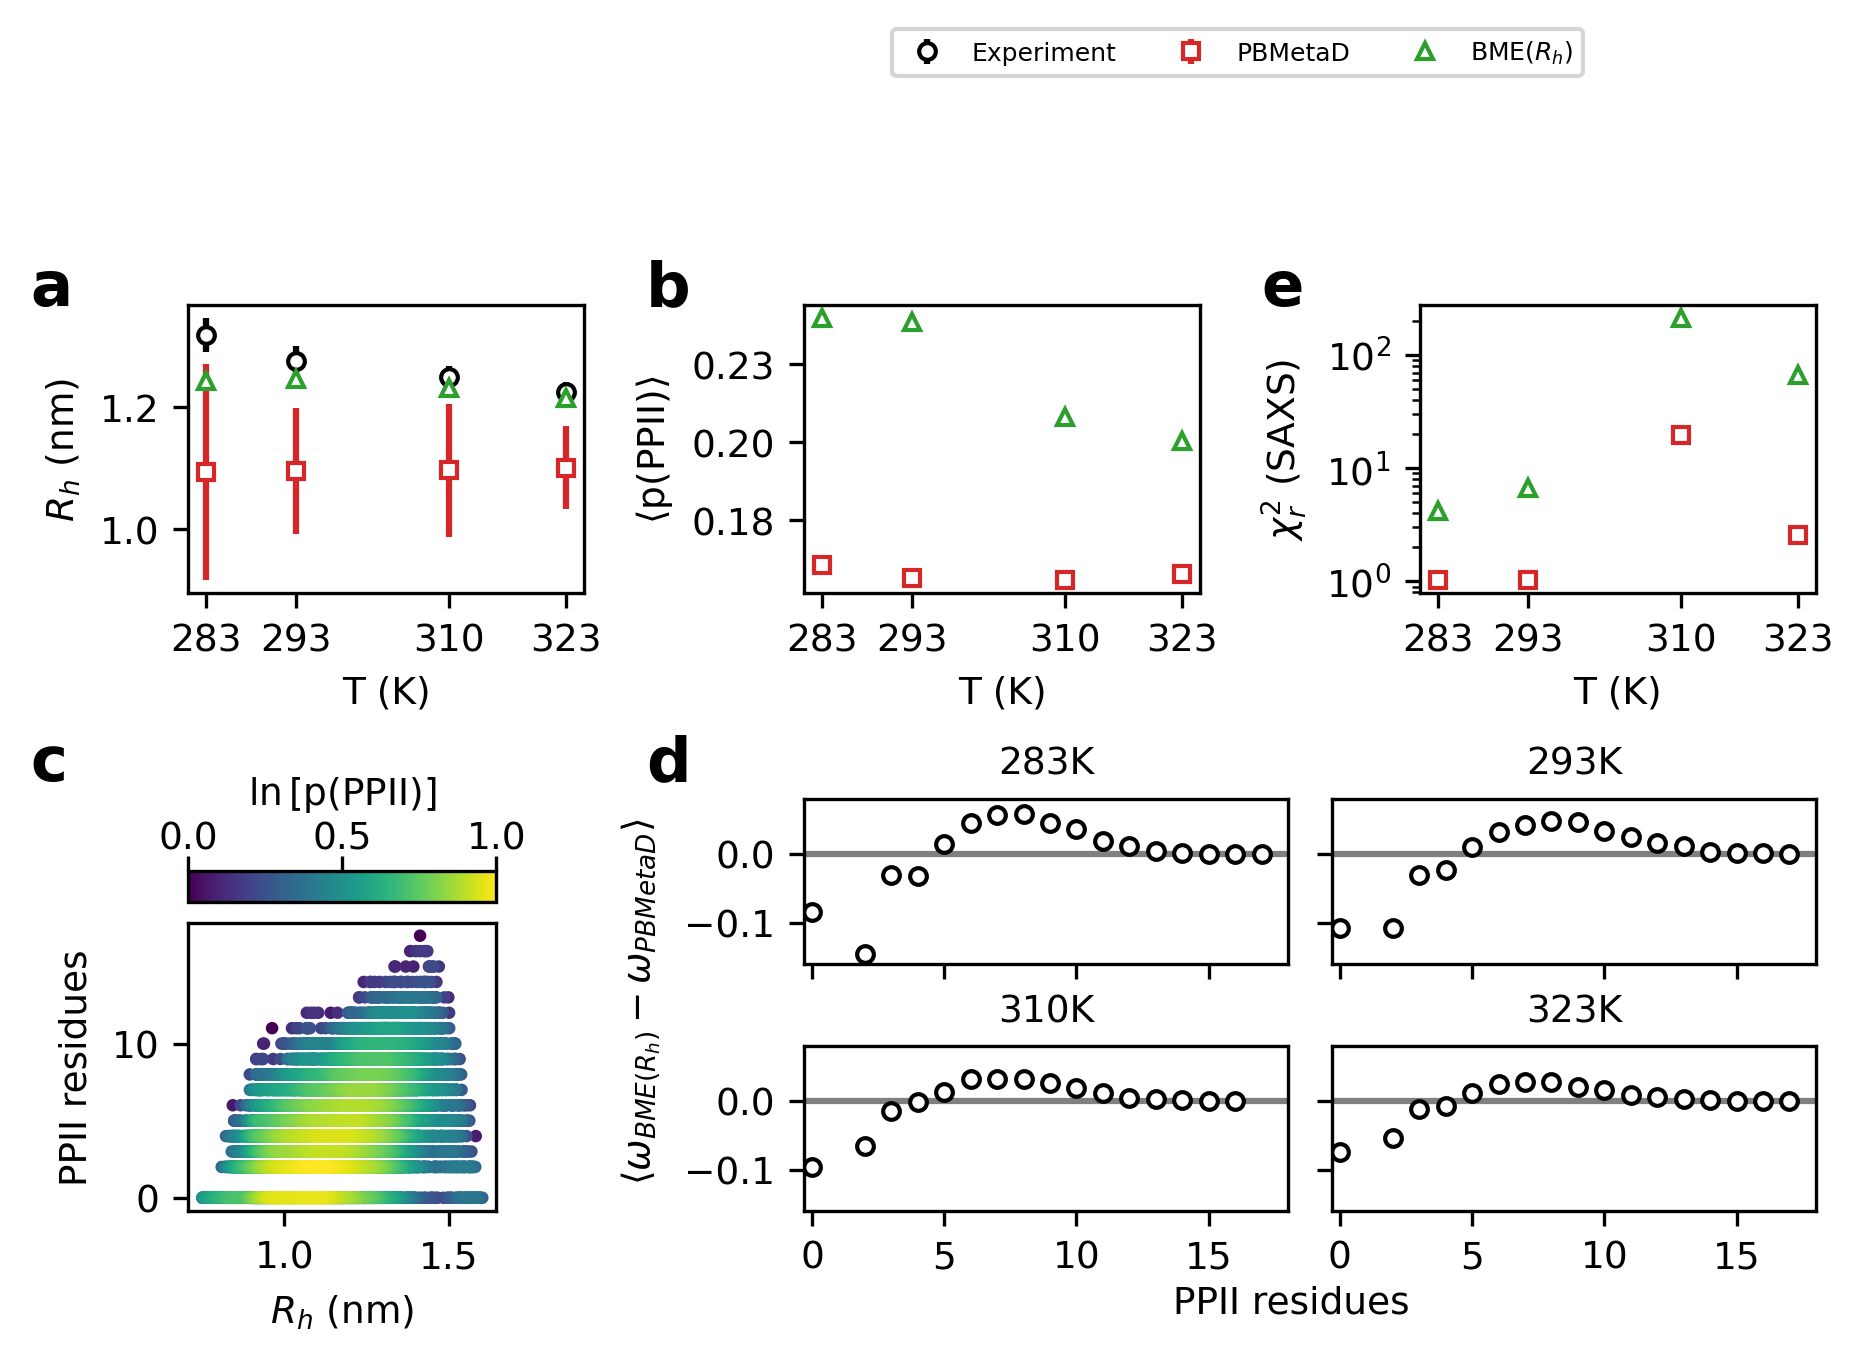

In [93]:
### mpl.rcParams.update({'font.size': 9})
fig = plt.figure(figsize=(7,4), dpi=300)
gs = GridSpec(nrows=4+4, ncols=15+4, figure=fig, wspace=1,hspace=2)

ax1 = fig.add_subplot(gs[0:3, 0:5])
ax2 = fig.add_subplot(gs[0:3, 7:12])
ax3 = fig.add_subplot(gs[0:3, 14:19])
ax4 = fig.add_subplot(gs[4:6, 7:13])
ax5 = fig.add_subplot(gs[4:6, 13:19])
ax6 = fig.add_subplot(gs[6:8, 7:13])
ax7 = fig.add_subplot(gs[6:8, 13:19])
ax8 = fig.add_subplot(gs[4:8, 0:4])

l1=ax1.errorbar(T, Rh_exp[...,0], Rh_exp[...,1], ls='', marker='o',c='k',label=r'Experiment',markersize=4, mfc='w')
l2=ax1.errorbar(T, Rh_av_metad[...,0], Rh_av_metad[...,1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
l3=ax1.errorbar(T, Rh_av_rh_bme, ls='', marker='^',c='tab:green',label=r'BME($R_h$)',markersize=4, mfc='w')
#ax1.errorbar(T, Rh_av_rh_bme_323, ls='', marker='v',c='tab:green',label=r'BME($R_h$)-323K Prior',markersize=4, mfc='w')
ax1.set_xticks(T)
ax1.set_xlabel('T (K)')
ax1.set_ylabel(r'$R_h$ (nm)')

ax2.errorbar(T, av_ppii_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
ax2.errorbar(T, av_ppii_bme_rh, ls='', marker='^',c='tab:green',label=r'BME($R_h$)',markersize=4, mfc='w')
#ax2.errorbar(T, av_ppii_bme_rh_323, ls='', marker='v',c='tab:green',label=r'BME($R_h$)-323 K Prior',markersize=4, mfc='w')
ax2.set_xticks(T)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel('T (K)')
ax2.set_ylabel(r'$\langle$p(PPII)$\rangle$')

ax3.errorbar(T, saxs_chi2_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
ax3.errorbar(T, saxs_chi2_bme_rh, ls='', marker='^',c='tab:green',label=r'BME($R_h$)',markersize=4, mfc='w')
#ax2.errorbar(T, saxs_chi2_, ls='', marker='v',c='tab:green',label=r'BME($R_h$)-323K Prior',markersize=4, mfc='w')
ax3.set_xticks(T)
ax3.set_xlabel('T (K)')
ax3.set_ylabel(r'$\chi^2_r$ (SAXS)')
ax3.set_yscale('log')

for x,t in zip([ax4,ax5,ax6,ax7],T):
    nss = list(set(per_frame_ss[t]))
    cnss = []
    dw = bme_rh_w[t] - metad_w[t]/metad_w[t].sum()
    for i in nss:
        ndx = np.where(np.array(per_frame_ss[t]) == i)
        cnss.append(dw[ndx].sum())
    x.errorbar(nss, cnss, ls='', marker='o',c='k',markersize=4, mfc='w')
    x.hlines(0,-0.3,18,color='0.5',zorder=-100)
    x.set_xlim(-0.3,18)
    x.set_title('{}K'.format(t), fontsize=9)
    x.set_ylim(-0.16,0.08)
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax7.set_yticklabels([])
fig.text(0.65, 0.04, r'PPII residues', ha='center')
fig.text(0.33, 0.3, r'$\langle \omega_{BME(R_{h})}-\omega_{PBMetaD} \rangle$', va='center', rotation='vertical', fontsize=9)

#h = np.histogram2d(per_frame_ss[323],check(Rh_array[323])[0::10], bins=10)
#ax8.contour(-np.log(h[0]),levels=1,extent=(h[2][0],h[2][-1],h[1][0],h[1][-1]))
x, y = check(Rh_array[323])[0::10][idx], np.array(per_frame_ss[323])[idx]
im = ax8.scatter(x,y,c=z,s=4)
cbar = plt.colorbar(im, ax=ax8, location = 'top', fraction=0.25, aspect=10, format='%.1f', ticks=[0,0.5,1], label=r'$\ln$[p(PPII)]', )
cbar.ax.tick_params(pad=0)
#ax8.errorbar(check(Rh_array[323])[0::10], per_frame_ss[323], ls='', marker='o',c='tab:blue',markersize=4)
ax8.set_ylabel('PPII residues')
ax8.set_xlabel(r'$R_h$ (nm)')

ax1.text(-0.4,1, 'a', fontsize=15, weight='bold', transform=ax1.transAxes)
ax2.text(-0.4,1, 'b', fontsize=15, weight='bold', transform=ax2.transAxes)
ax3.text(-0.4,1, 'e', fontsize=15, weight='bold', transform=ax3.transAxes)
ax1.text(-0.4,-0.65, 'c', fontsize=15, weight='bold', transform=ax1.transAxes)
ax2.text(-0.4,-0.65, 'd', fontsize=15, weight='bold', transform=ax2.transAxes)

ax2.legend([l1,l2,l3],['Experiment','PBMetaD','BME($R_h$)'],fontsize=6, bbox_to_anchor=(2,2,0,0), ncol=3)

plt.savefig('fig3.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

## Figure 4

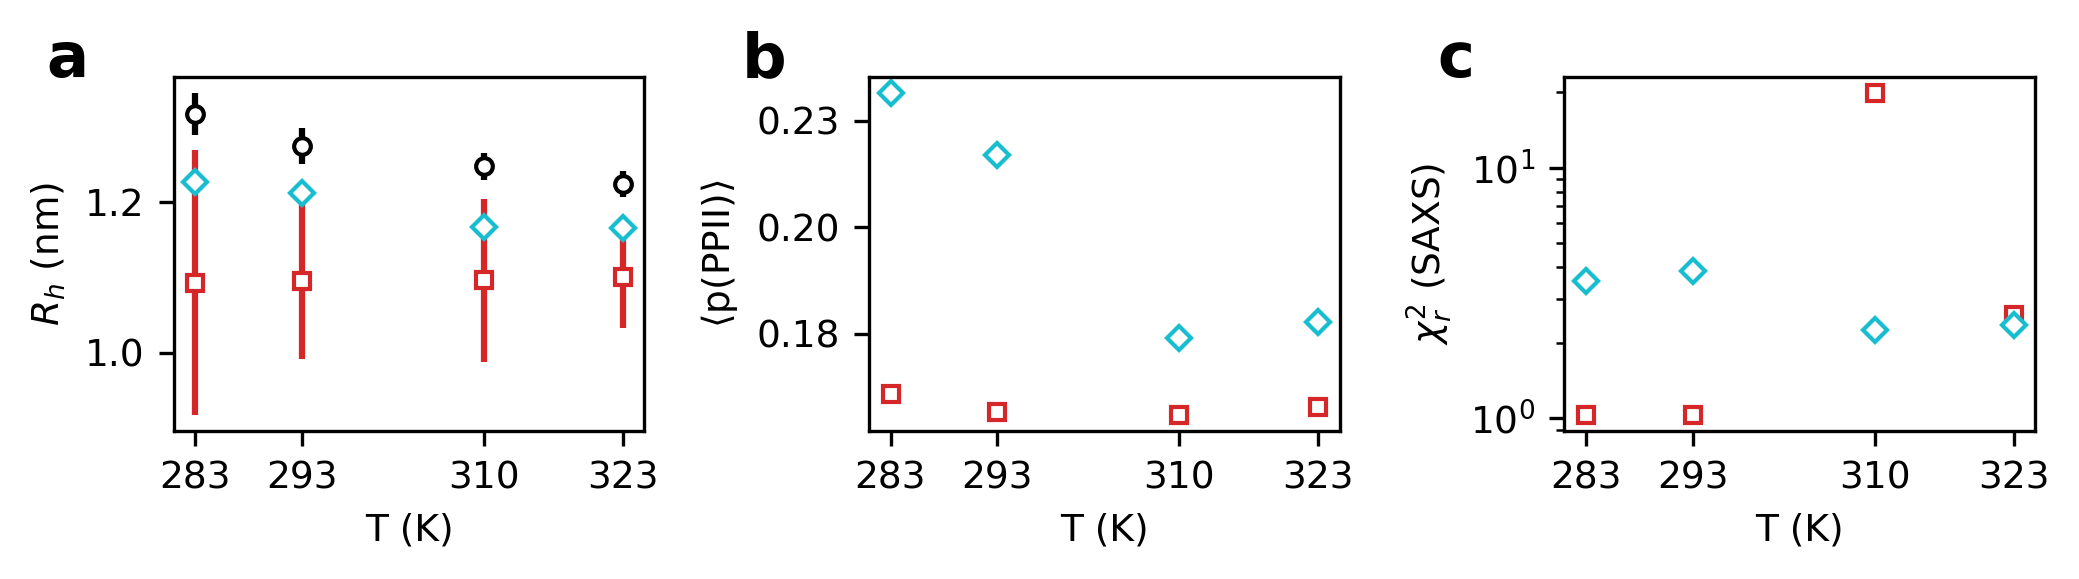

In [133]:
mpl.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7,2), dpi=300)
axs = axs.flatten()

l1=axs[0].errorbar(T, Rh_exp[...,0], Rh_exp[...,1], ls='', marker='o',c='k',label=r'Experimental',markersize=4, mfc='w')
l2=axs[0].errorbar(T, Rh_av_metad[...,0], Rh_av_metad[...,1], ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
l3=axs[0].errorbar(T, Rh_av_bme_comb, ls='', marker='D',c='tab:cyan',label=r'BME(SAXS+$R_h$)',markersize=4, mfc='w')
axs[0].set_xticks(T)
axs[0].set_xlabel('T (K)')
axs[0].set_ylabel(r'$R_h$ (nm)')


axs[1].errorbar(T, av_ppii_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
axs[1].errorbar(T, av_ppii_bme_comb, ls='', marker='D',c='tab:cyan',label=r'BME(SAXS+$R_h$)',markersize=4, mfc='w')
axs[1].set_xticks(T)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].set_xlabel('T (K)')
axs[1].set_ylabel(r'$\langle$p(PPII)$\rangle$')

axs[2].errorbar(T, saxs_chi2_metad, ls='', marker='s',c='tab:red',label=r'PBMetaD',markersize=4, mfc='w')
axs[2].errorbar(T, saxs_chi2_bme_comb, ls='', marker='D',c='tab:cyan',label=r'BME(SAXS+$R_h$)',markersize=4, mfc='w')
axs[2].set_xticks(T)
axs[2].set_xlabel('T (K)')
axs[2].set_ylabel(r'$\chi^2_r$ (SAXS)')
axs[2].set_yscale('log')

for a,l in zip(axs,['a','b','c']):
    a.text(-0.27,1, l, fontsize=15, weight='bold', transform=a.transAxes)
    
#axs[1].legend([l1,l2,l3],['Experiment','PBMetaD','BME(SAXS+$R_h$)'],fontsize=8, ncol=3, bbox_to_anchor=(1.3,3,0,0))#, bbox_to_anchor=(2,1,0,0)).set_zorder(1)
    
plt.tight_layout()
plt.savefig('fig4.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Figure 5

In [298]:
rh_calvados = np.loadtxt('/storage1/francesco/PROJECTS/RH/Hst5/Rh_Kirk_Ca.dat')

t = md.load_dcd('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/Hst5/traj.dcd', top='/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/Hst5/top.pdb')
df = analyse.residues.set_index('one')
residues = [res.name for res in t.top.atoms]
masses = df.loc[residues,'MW'].values
rg_calvados = md.compute_rg(t,masses=masses)

disp = np.histogram2d(Rh_array[293],BLOCK_rg[293].x, weights=BLOCK_rg[293].w, bins=50)
disp_rew = np.histogram2d(Rh_array[293][0::10],BLOCK_rg[293].x[0::10], weights=w_bme_comb[1], bins=40)
calv = np.histogram2d(rh_calvados,rg_calvados[0::10], bins=20)

In [299]:
disp_fes = -np.log(disp[0])*0.008314462618*293
disp_fes -= disp_fes.min()
disp_rew_fes = -np.log(disp_rew[0])*0.008314462618*293
disp_rew_fes -= disp_rew_fes.min()

<ipython-input-299-5c6f79b0cd64>:1: RuntimeWarning: divide by zero encountered in log
  disp_fes = -np.log(disp[0])*0.008314462618*293
<ipython-input-299-5c6f79b0cd64>:3: RuntimeWarning: divide by zero encountered in log
  disp_rew_fes = -np.log(disp_rew[0])*0.008314462618*293


<ipython-input-300-2649708ed04e>:13: RuntimeWarning: divide by zero encountered in log
  ax.contour(-np.log(calv[0]),levels=1,extent=(calv[2][0],calv[2][-1],calv[1][0],calv[1][-1]),colors='#ffbf00',linewidths=2)


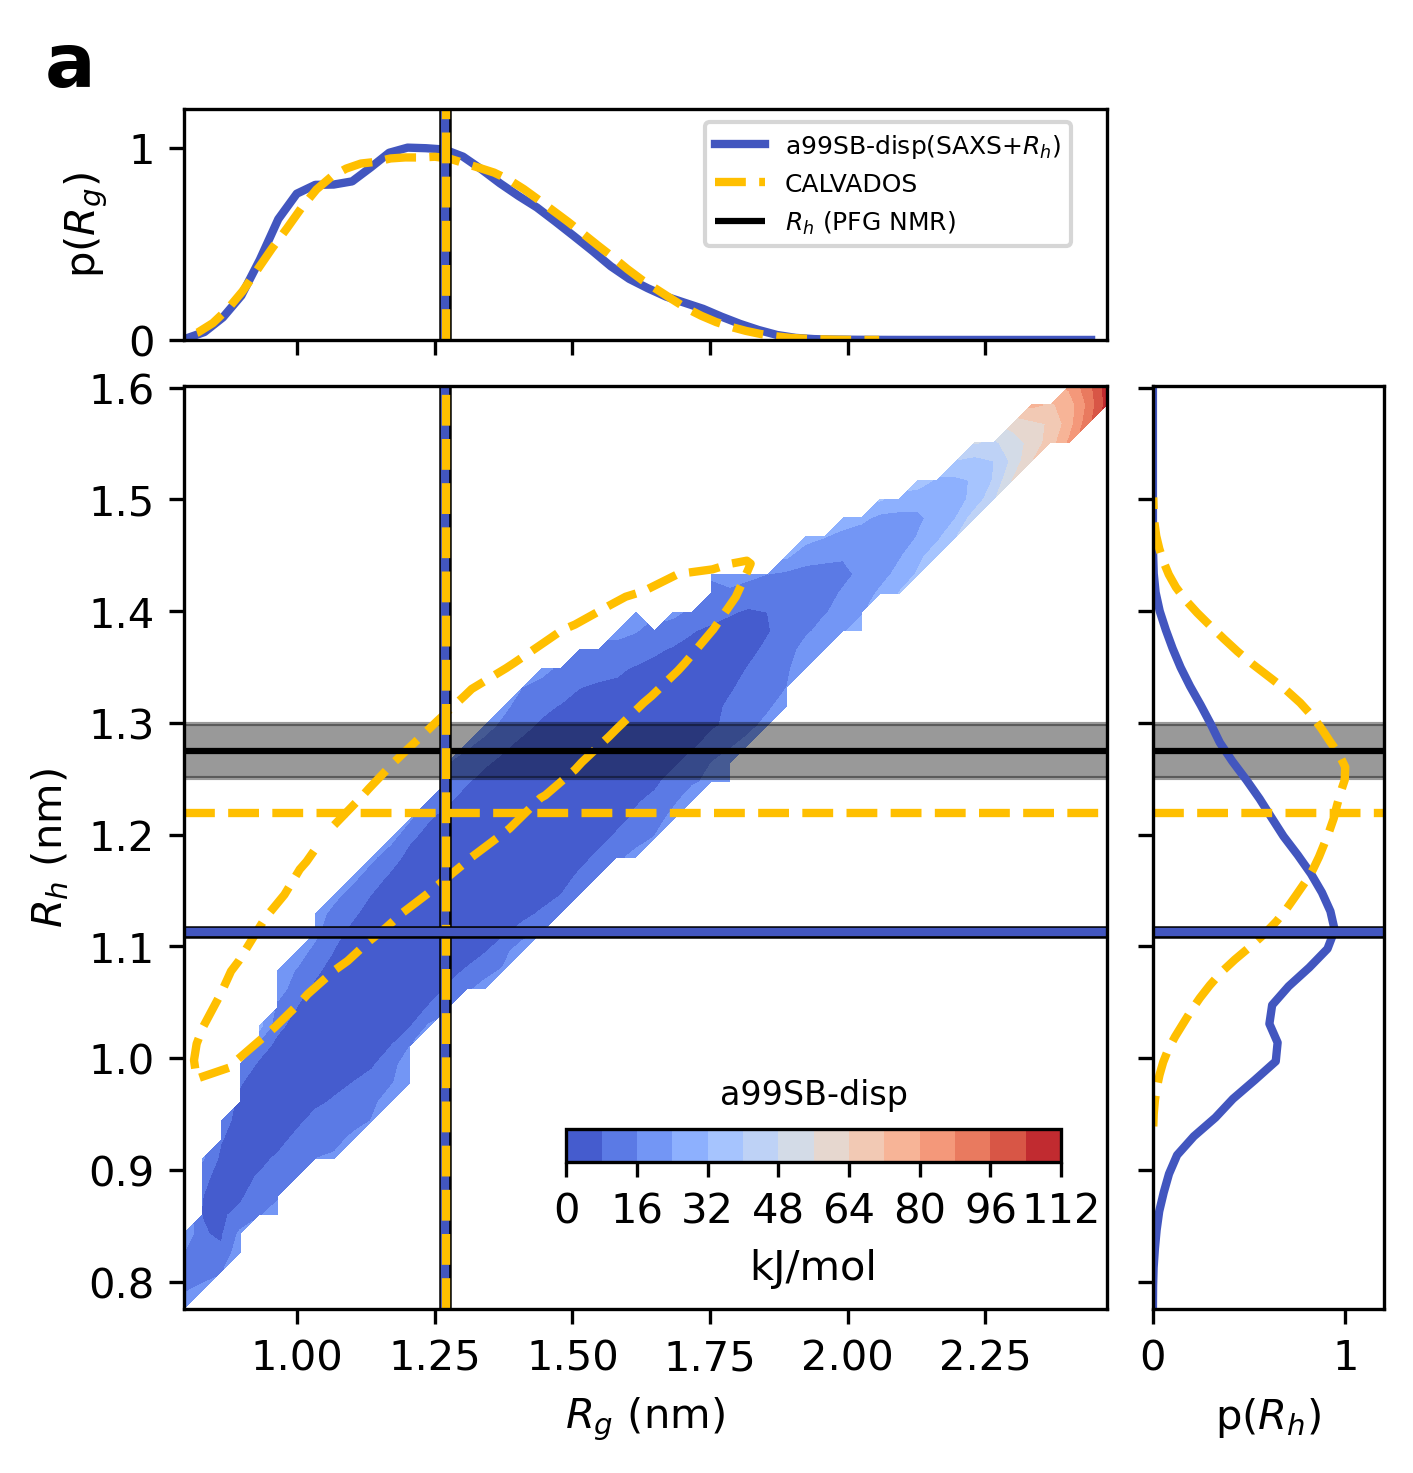

In [300]:
#### mpl.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(5, 5), dpi=300)

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.08, hspace=0.08)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])


im = ax.contourf(disp_fes, cmap='coolwarm',levels=15,extent=(disp[2][0],disp[2][-1],disp[1][0],disp[1][-1]))
ax.contour(-np.log(calv[0]),levels=1,extent=(calv[2][0],calv[2][-1],calv[1][0],calv[1][-1]),colors='#ffbf00',linewidths=2)
ax.hlines(Rh_exp[1][0],disp[2][0],disp[2][-1],label='Experimental',color='k')
ax.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax.set_xlim(disp[2][0],disp[2][-1])
ax.set_ylim(disp[1][0],disp[1][-1])
ax_histy.set_ylim(disp[1][0],disp[1][-1])
ax_histx.set_xlim(disp[2][0],disp[2][-1])

rg_disp = kde_rg(BLOCK_rg[293].x[0::10],w=metad_w[293])
scale = np.max(rg_disp[1])
rg_calv = kde_rg(rg_calvados)
ax_histx.plot(rg_disp[0],rg_disp[1]/scale,lw=2,label=r'a99SB-disp(SAXS+$R_h$)',c='#4256BF')
ax_histx.plot(rg_calv[0],rg_calv[1]/scale,c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.vlines(rg_disp[2],disp[1][0],disp[1][-1],color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histx.vlines(rg_disp[2],0,1.2,color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.vlines(rg_calv[2],disp[1][0],disp[1][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histx.vlines(rg_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

rh_calv = kde_rh(rh_calvados)
scale = np.max(rh_calv[1])
rh_disp = kde_rh(Rh_array[293][0::10],w=metad_w[293])
ax_histy.plot(rh_disp[1]/scale,rh_disp[0],lw=2,label=r'a99SB-disp(SAXS+$R_h$)',c='#4256BF')
ax_histy.plot(rh_calv[1]/scale,rh_calv[0],c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.hlines(rh_disp[2],disp[2][0],disp[2][-1],color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histy.hlines(rh_disp[2],0,1.2,color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.hlines(rh_calv[2],disp[2][0],disp[2][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histy.hlines(rh_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

ax_histx.set_xticklabels([])
ax_histx.set_ylabel(r'p($R_g$)')
ax_histx.set_ylim(0,1.2)
ax_histy.set_yticklabels([])
ax_histy.set_xlabel(r'p($R_h$)')
ax_histy.hlines(Rh_exp[1][0],0,1.2,label=r'$R_h$ (PFG NMR)',color='k')
ax_histy.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax_histy.set_xlim(0,1.2)
ax.set_xlabel(r'$R_g$ (nm)')
ax.set_ylabel(r'$R_h$ (nm)')
ax.set_box_aspect(1)

cbax = fig.add_axes([0.47, 0.12, 0.1, 0.1])
cbax.axis('off')
cbax.set_title(r'a99SB-disp',fontsize=8)
cb = plt.colorbar(im, ax=cbax, orientation='horizontal',shrink=3.3,fraction=1,format='%.d',label='kJ/mol',aspect=15)

ax_histx.text(-0.15,1.1, 'a', fontsize=18, weight='bold', transform=ax_histx.transAxes)
ax_histy.legend(fontsize=6,bbox_to_anchor=(-0.3,1.3,0,0))

plt.savefig('fig5a.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

<ipython-input-304-33396b1ece87>:13: RuntimeWarning: divide by zero encountered in log
  ax.contour(-np.log(calv[0]),levels=1,extent=(calv[2][0],calv[2][-1],calv[1][0],calv[1][-1]),colors='#ffbf00',linewidths=2)


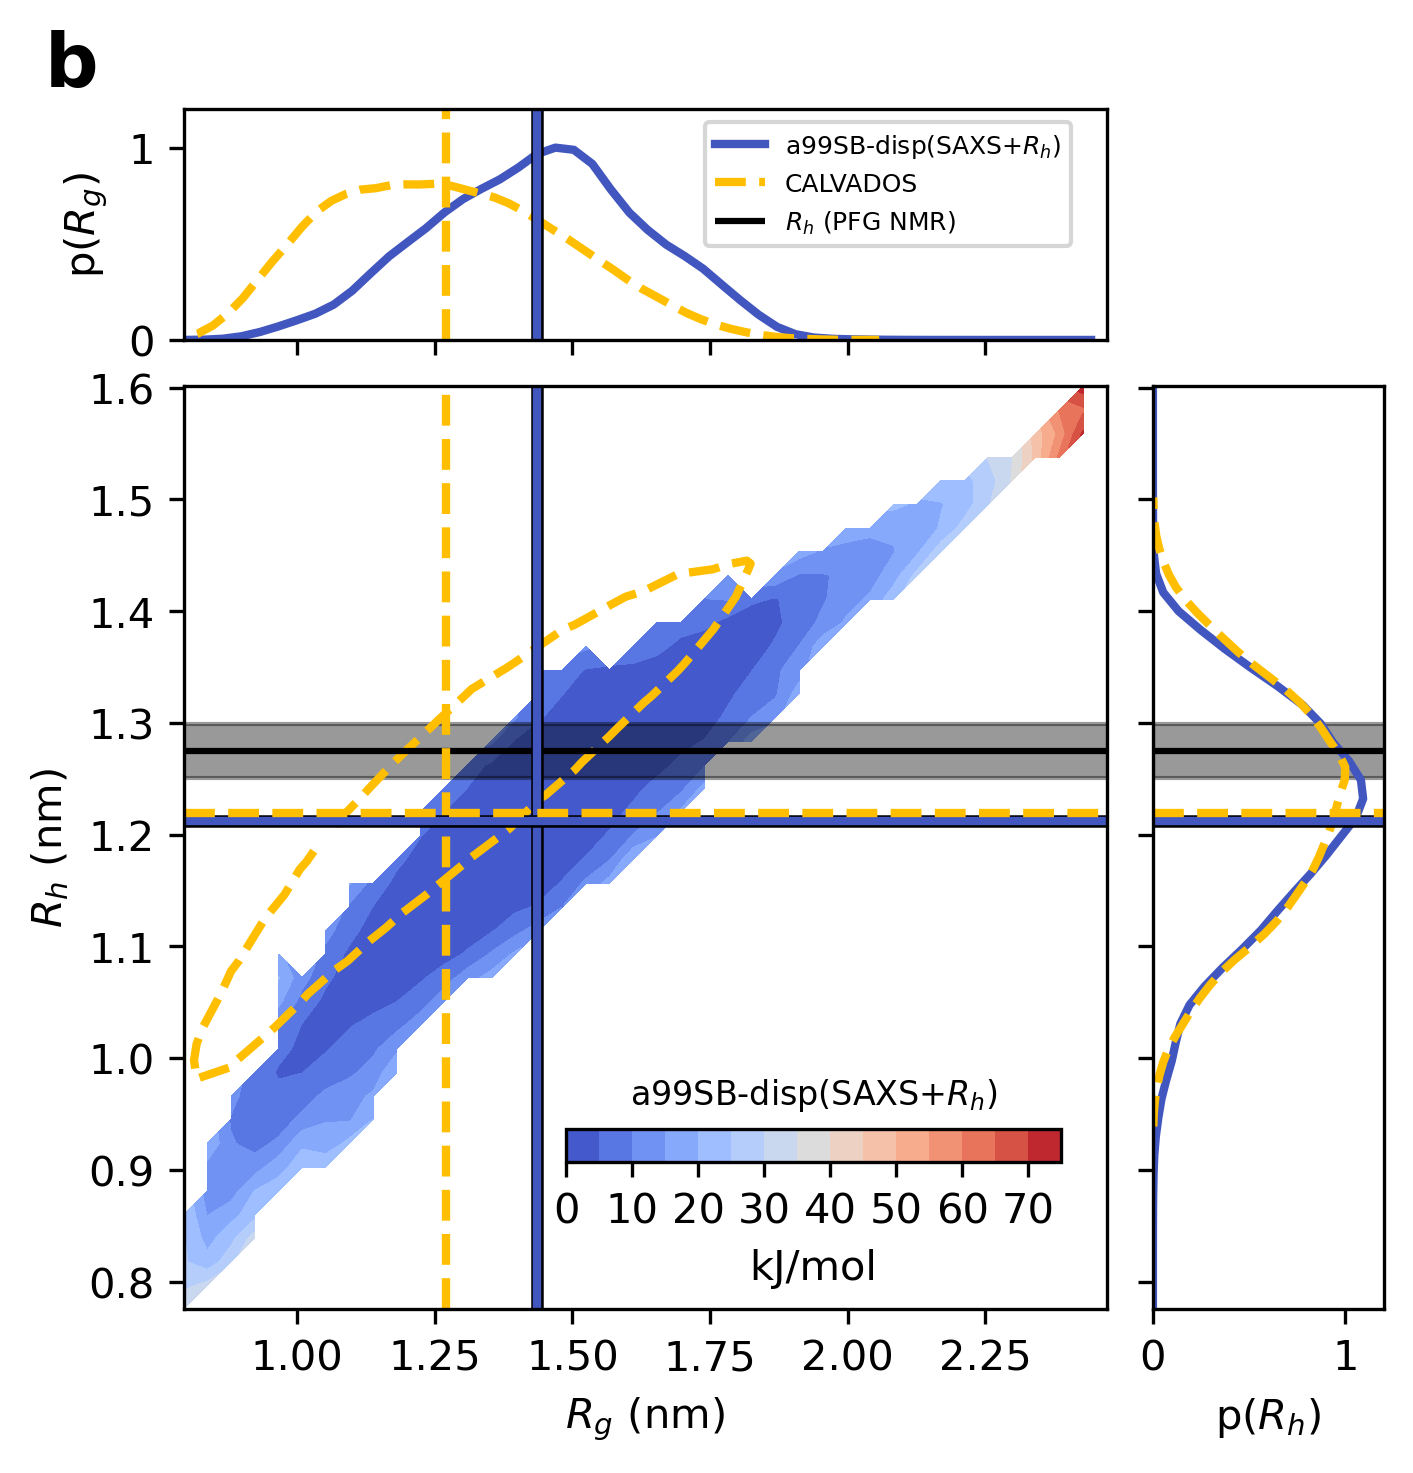

In [304]:
mpl.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(5, 5), dpi=300)

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.08, hspace=0.08)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])


im = ax.contourf(disp_rew_fes, cmap='coolwarm',levels=15,extent=(disp[2][0],disp[2][-1],disp[1][0],disp[1][-1]))
ax.contour(-np.log(calv[0]),levels=1,extent=(calv[2][0],calv[2][-1],calv[1][0],calv[1][-1]),colors='#ffbf00',linewidths=2)
ax.hlines(Rh_exp[1][0],disp[2][0],disp[2][-1],label='Experimental',color='k')
ax.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax.set_xlim(disp[2][0],disp[2][-1])
ax.set_ylim(disp[1][0],disp[1][-1])
ax_histy.set_ylim(disp[1][0],disp[1][-1])
ax_histx.set_xlim(disp[2][0],disp[2][-1])

rg_disp = kde_rg(BLOCK_rg[293].x[0::10],w=w_bme_comb[1])
scale = np.max(rg_disp[1])
rg_calv = kde_rg(rg_calvados)
ax_histx.plot(rg_disp[0],rg_disp[1]/scale,lw=2,label=r'a99SB-disp(SAXS+$R_h$)',c='#4256BF')
ax_histx.plot(rg_calv[0],rg_calv[1]/scale,c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.vlines(rg_disp[2],disp[1][0],disp[1][-1],color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histx.vlines(rg_disp[2],0,1.2,color='#4256BF',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.vlines(rg_calv[2],disp[1][0],disp[1][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histx.vlines(rg_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

rh_calv = kde_rh(rh_calvados)
scale = np.max(rh_calv[1])
rh_disp = kde_rh(Rh_array[293][0::10],w=w_bme_comb[1])
ax_histy.plot(rh_disp[1]/scale,rh_disp[0],lw=2,label=r'a99SB-disp(SAXS+$R_h$)',c='#4256BF')
ax_histy.plot(rh_calv[1]/scale,rh_calv[0],c='#ffbf00',ls='dashed',lw=2,label='CALVADOS')
ax.hlines(rh_disp[2],disp[2][0],disp[2][-1],color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax_histy.hlines(rh_disp[2],0,1.2,color='#4256BF',lw=2,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
ax.hlines(rh_calv[2],disp[2][0],disp[2][-1],color='#ffbf00',ls='dashed',lw=2)
ax_histy.hlines(rh_calv[2],0,1.2,color='#ffbf00',ls='dashed',lw=2)

ax_histx.set_xticklabels([])
ax_histx.set_ylabel(r'p($R_g$)')
ax_histx.set_ylim(0,1.2)
ax_histy.set_yticklabels([])
ax_histy.set_xlabel(r'p($R_h$)')
ax_histy.hlines(Rh_exp[1][0],0,1.2,label=r'$R_h$ (PFG NMR)',color='k')
ax_histy.fill_between((0,10),Rh_exp[1][0]-Rh_exp[1][1],Rh_exp[1][0]+Rh_exp[1][1],color='k',alpha=0.4)
ax_histy.set_xlim(0,1.2)
ax.set_xlabel(r'$R_g$ (nm)')
ax.set_ylabel(r'$R_h$ (nm)')
ax.set_box_aspect(1)

cbax = fig.add_axes([0.47, 0.12, 0.1, 0.1])
cbax.axis('off')
cbax.set_title(r'a99SB-disp(SAXS+$R_h$)',fontsize=8)
cb = plt.colorbar(im, ax=cbax, orientation='horizontal',shrink=3.3,fraction=1,format='%.d',label='kJ/mol',aspect=15)

ax_histx.text(-0.15,1.1, 'b', fontsize=18, weight='bold', transform=ax_histx.transAxes)
ax_histy.legend(fontsize=6,bbox_to_anchor=(-0.3,1.3,0,0))

plt.savefig('fig5b.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')